# Análise de Dados de Desempenho e Temperatura
Este notebook carrega os CSVs referentes aos três cenários de teste (sem base refrigeradora, base manual e base automática), calcula estatísticas descritivas (temperatura, RPM, FPS, throttling e potência) e gera visualizações para análise comparativa.

# Funções auxiliares para plotagem de gráfico

In [ ]:
def plot_mean(df_summary, metric_prefixes, title, ylabel, y_min=None):
    """
    Gera um gráfico de barras agrupado, mostrando APENAS a MÉDIA para cada métrica,
    separadamente para cada tipo de placa.

    Args:
        df_summary (pd.DataFrame): O DataFrame de resumo com as estatísticas.
        metric_prefixes (list[str]): Uma lista de prefixos de métricas (ex: ['CPU_Temp', 'GPU_Temp']).
        title (str): O título do gráfico.
        ylabel (str): O rótulo do eixo y.
        y_min (float, optional): O valor mínimo para o eixo Y. Se None, o padrão do Matplotlib é usado.
    """
    if isinstance(metric_prefixes, str):
        metric_prefixes = [metric_prefixes]

    # Lógica de Filtragem: Manter uma placa se QUALQUER uma de suas médias for > 0
    mean_cols = [f'{prefix}_Mean' for prefix in metric_prefixes]
    mask = (df_summary[mean_cols] > 0).any(axis=1)
    df_filtered = df_summary.loc[mask]

    if df_filtered.empty:
        print(f"Aviso: Nenhuma placa atendeu ao critério (pelo menos uma média > 0) para as métricas {metric_prefixes}. O gráfico não será gerado.")
        return

    labels = df_filtered.index
    x = np.arange(len(labels))  # As posições dos grupos no eixo X

    # --- Lógica de Plotagem Modificada ---
    n_metrics = len(metric_prefixes)
    # Largura total de um grupo de barras (ex: para a "Placa 1")
    group_width = 0.6
    # Largura de uma única barra (agora só temos 1 barra por métrica)
    bar_width = group_width / n_metrics

    # Calcula os deslocamentos para centralizar o grupo de barras
    offsets = np.arange(n_metrics) * bar_width - (group_width / 2) + (bar_width / 2)

    fig, ax = plt.subplots(figsize=(12, 7))

    # Itera sobre cada métrica para criar sua barra de Média
    for i, prefix in enumerate(metric_prefixes):
        mean_values = df_filtered[f'{prefix}_Mean']

        # Calcula a posição da barra da métrica atual
        position = x + offsets[i]

        # Cria a barra de Média com seu respectivo rótulo para a legenda
        rects = ax.bar(position, mean_values, bar_width, label=f'{prefix} Média')
        autolabel(ax, rects) # Coloca o valor no topo da barra

    # --- Configurações Finais do Gráfico ---
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")

    if y_min is not None:
        ax.set_ylim(bottom=y_min)

    ax.legend()
    fig.tight_layout()
    plt.show()


def autolabel(ax, rects):
    """Função auxiliar para colocar o valor em cima de cada barra."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

In [ ]:
def plot_min_max_mean(df_summary, metric_prefix, title, ylabel, ymin=None, ymax=None, metric_prefix_renamed=None):
    """
    Gera um gráfico de barras comparativo mostrando mínima, máxima e média
    para uma métrica específica, agrupado por tipo de placa.
    Plota apenas os tipos de placa cuja média para a métrica é maior que 0.

    Args:
        df_summary (pd.DataFrame): O DataFrame de resumo com as estatísticas.
        metric_prefix (str): O prefixo da métrica (ex: 'CPU_Temp', 'GPU_Core_Temp', 'FPS').
        title (str): O título do gráfico.
        ylabel (str): O rótulo do eixo y.
    """
    # --- INÍCIO DA MODIFICAÇÃO ---

    # 1. Filtra o DataFrame para incluir apenas as linhas onde a média é > 0
    df_filtered = df_summary[df_summary[f'{metric_prefix}_Mean'] > 0]

    # 2. Verifica se o dataframe ficou vazio após o filtro
    if df_filtered.empty:
        print(f"Aviso: Nenhum tipo de placa atendeu ao critério (média > 0) para a métrica '{metric_prefix}'. O gráfico não será gerado.")
        return # Encerra a função para não gerar um gráfico vazio

    # 3. Usa o DataFrame filtrado para extrair os dados
    labels = df_filtered.index
    mean_values = df_filtered[f'{metric_prefix}_Mean']
    max_values = df_filtered[f'{metric_prefix}_Max']
    min_values = df_filtered[f'{metric_prefix}_Min']

    # --- FIM DA MODIFICAÇÃO ---


    x = np.arange(len(labels))  # a localização dos labels
    width = 0.2  # a largura das barras

    fig, ax = plt.subplots(figsize=(12, 7))
    if metric_prefix_renamed:
        metric_prefix = metric_prefix_renamed
    rects1 = ax.bar(x - width, min_values, width, label='Minima')
    rects2 = ax.bar(x, mean_values, width, label='Média')
    rects3 = ax.bar(x + width, max_values, width, label='Máxima')

    # Adiciona texto para os rótulos, título, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(None)
    # Define o mínimo do eixo Y
    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    # Define o máximo do eixo X
    if ymax is not None:
        ax.set_ylim(top=ymax)
    ax.legend()

    def autolabel(rects):
        """Anexa um rótulo de texto acima de cada barra, mostrando sua altura."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 pontos de deslocamento vertical
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()

    plt.show()

In [ ]:
def plot_max_mean(df_summary, metric_prefixes, title, ylabel, ymin=None, ymax=None, metric_prefixes_renamed=None):
    """
    Gera um gráfico de barras agrupado, mostrando Média e Máxima para cada métrica,
    separadamente para cada tipo de placa.

    Args:
        df_summary (pd.DataFrame): O DataFrame de resumo com as estatísticas.
        metric_prefixes (list[str]): Lista de prefixos de métricas (ex: ['CPU_Temp', 'GPU_Temp']).
        title (str): Título do gráfico.
        ylabel (str): Rótulo do eixo y.
        ymin (float, optional): Valor mínimo do eixo Y. Default é 0.
    """

    def autolabel(ax, rects):
      for rect in rects:
          height = rect.get_height()
          ax.annotate(f'{height:.1f}',
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center', va='bottom',
                      fontsize=13)

    if isinstance(metric_prefixes, str):
        metric_prefixes = [metric_prefixes]

    # --- Lógica de Filtragem ---
    mean_cols = [f'{prefix}_Mean' for prefix in metric_prefixes]
    mask = (df_summary[mean_cols] > 0).any(axis=1)
    df_filtered = df_summary[mask]

    if df_filtered.empty:
        print(f"Aviso: Nenhuma placa atendeu ao critério (pelo menos uma média > 0) para as métricas {metric_prefixes}. O gráfico não será gerado.")
        return

    labels = df_filtered.index
    x = np.arange(len(labels))

    n_metrics = len(metric_prefixes)
    total_bars_per_group = n_metrics * 2
    group_width = 0.8
    bar_width = group_width / total_bars_per_group

    fig, ax = plt.subplots(figsize=(8, 8))

    for i, prefix in enumerate(metric_prefixes):
        mean_values = df_filtered[f'{prefix}_Mean']
        max_values = df_filtered[f'{prefix}_Max']

        offset_mean = (2 * i) - (total_bars_per_group / 2) + 0.5
        offset_max = (2 * i + 1) - (total_bars_per_group / 2) + 0.5

        pos_mean = x + offset_mean * bar_width
        pos_max = x + offset_max * bar_width

        if metric_prefixes_renamed:
            prefix = metric_prefixes_renamed[i]
        rects_mean = ax.bar(pos_mean, mean_values, bar_width, label=f'{prefix} média')
        rects_max = ax.bar(pos_max, max_values, bar_width, label=f'{prefix} máxima')

        autolabel(ax, rects_mean)
        autolabel(ax, rects_max)

    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=14)

    # Define o mínimo do eixo Y
    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    # else:
    #     ax.set_ylim(bottom=0)
    # # Define o máximo do eixo Y
    if ymax is not None:
        ax.set_ylim(top=ymax)
    #     ax.set_ylim(top=None)
    ax.legend()
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_metrics_flexible(df_summary, metric_prefixes, stats_to_plot, title, ylabel,
                          y_min=None, y_max=None, metric_prefixes_renamed=None, stats_renamed=None,
                          show_diff_percent=False): # <-- NOVO PARÂMETRO
    """
    Gera um gráfico de barras customizável.

    Args:
        df_summary (pd.DataFrame): O DataFrame com as estatísticas.
        metric_prefixes (list or str): Prefixos das métricas.
        stats_to_plot (list or str): Estatísticas a serem plotadas ('Min', 'Mean', 'Max').
        title (str): Título do gráfico.
        ylabel (str): Rótulo do eixo y.
        y_min (float, optional): Mínimo do eixo Y.
        y_max (float, optional): Máximo do eixo Y.
        metric_prefixes_renamed (list, optional): Nomes de exibição para as métricas.
        stats_renamed (dict, optional): Nomes de exibição para as estatísticas.
        show_diff_percent (bool, optional): Se True, mostra a diferença percentual em relação à primeira linha.
    """
    # --- 1. Validação e Preparação dos Parâmetros ---
    if isinstance(metric_prefixes, str):
        metric_prefixes = [metric_prefixes]
    if isinstance(stats_to_plot, str):
        stats_to_plot = [stats_to_plot]
    if not stats_to_plot:
        print("Erro: A lista 'stats_to_plot' não pode estar vazia.")
        return

    # --- 2. Lógica de Filtragem ---
    mean_cols = [f'{prefix}_Mean' for prefix in metric_prefixes]
    existing_mean_cols = [col for col in mean_cols if col in df_summary.columns]
    if not existing_mean_cols:
        print(f"Aviso: Nenhuma coluna de média encontrada para os prefixos {metric_prefixes}. O gráfico não será gerado.")
        return
    mask = (df_summary[existing_mean_cols] > 0).any(axis=1)
    df_filtered = df_summary.loc[mask]
    if df_filtered.empty:
        print("Aviso: Nenhuma entrada encontrada após a filtragem. O gráfico não será gerado.")
        return

    # --- INÍCIO DA MODIFICAÇÃO ---
    # Define a linha de base para o cálculo percentual
    baseline_row = None
    if show_diff_percent and len(df_filtered) > 1:
        baseline_row = df_filtered.iloc[0]

    def _autolabel(ax, rects, column_for_diff):
        """Função aninhada para colocar o valor e a diferença % em cima de cada barra."""
        # Itera sobre cada barra (rect) e sua posição no eixo X (dado por i)
        for i, rect in enumerate(rects):
            height = rect.get_height()
            label_text = f'{height:.1f}'

            # Se a opção estiver ativa, calcula e anexa o percentual
            # O cálculo só é feito para as barras que NÃO SÃO da linha de base (i > 0)
            if show_diff_percent and baseline_row is not None and i > 0:
                baseline_value = baseline_row[column_for_diff]
                if baseline_value != 0:
                    diff_percent = ((height - baseline_value) / baseline_value) * 100
                    # Adiciona o sinal de '+' para valores positivos
                    sign = '+' if diff_percent >= 0 else ''
                    label_text += f'\n({sign}{diff_percent:.1f}%)'

            ax.annotate(label_text,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.5))

    # --- FIM DA MODIFICAÇÃO ---

    # --- 3. Lógica de Plotagem Dinâmica ---
    labels = df_filtered.index
    x = np.arange(len(labels))

    n_metrics = len(metric_prefixes)
    n_stats = len(stats_to_plot)
    total_bars_per_group = n_metrics * n_stats
    group_width = 0.8
    bar_width = group_width / total_bars_per_group if total_bars_per_group > 0 else group_width


    if total_bars_per_group <= 2:
      fig, ax = plt.subplots(figsize=(8, 8))
    else:
      fig, ax = plt.subplots(figsize=(8, 8))

    for i, prefix in enumerate(metric_prefixes):
        for j, stat in enumerate(stats_to_plot):
            bar_index = i * n_stats + j
            offset = (bar_index - total_bars_per_group / 2 + 0.5) * bar_width
            position = x + offset

            column_name = f'{prefix}_{stat}'
            if column_name not in df_filtered.columns:
                print(f"Aviso: Coluna '{column_name}' não encontrada. Pulando.")
                continue
            values = df_filtered[column_name]

            display_prefix = metric_prefixes_renamed[i] if (metric_prefixes_renamed and i < len(metric_prefixes_renamed)) else prefix
            display_stat = stats_renamed.get(stat, stat) if stats_renamed else stat
            bar_label = f'{display_prefix} {display_stat}'

            rects = ax.bar(position, values, bar_width, label=bar_label)
            # Passa o nome da coluna para a função autolabel saber qual valor de base usar
            _autolabel(ax, rects.patches, column_name)

    # --- 4. Configurações Finais do Gráfico ---
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=12)

    if y_min is not None or y_max is not None:
        current_bottom, current_top = ax.get_ylim()
        ax.set_ylim(bottom=y_min if y_min is not None else current_bottom,
                    top=y_max if y_max is not None else current_top * 1.1) # Aumenta um pouco o topo para os rótulos
    else:
         current_bottom, current_top = ax.get_ylim()
         ax.set_ylim(bottom=current_bottom, top=current_top * 1.1)


    ax.legend(fontsize=11)
    ax.grid(False)
    fig.tight_layout()
    plt.show()

# --- REPLICANDO O COMPORTAMENTO DAS FUNÇÕES ANTIGAS ---

# # 1. Replicando `plot_min_max_mean` (Min, Média e Máxima de uma métrica)
# print("--- Exemplo 1: Replicando plot_min_max_mean ---")
# plot_metrics_flexible(
#     df_summary=df_exemplo,
#     metric_prefixes='CPU_Temp',  # Apenas uma métrica
#     stats_to_plot=['Min', 'Mean', 'Max'], # Três estatísticas
#     title='Temperatura da CPU (Min, Média, Máx)',
#     ylabel='Temperatura (°C)',
#     y_min=40
# )

# # 2. Replicando `plot_max_mean` (Média e Máxima de múltiplas métricas)
# print("\n--- Exemplo 2: Replicando plot_max_mean ---")
# plot_metrics_flexible(
#     df_summary=df_exemplo,
#     metric_prefixes=['CPU_Temp', 'GPU_Temp'], # Múltiplas métricas
#     stats_to_plot=['Mean', 'Max'], # Duas estatísticas
#     title='Temperaturas (Média e Máxima)',
#     ylabel='Temperatura (°C)'
# )

# # 3. Replicando `plot_mean` (Apenas a Média de múltiplas métricas)
# print("\n--- Exemplo 3: Replicando plot_mean ---")
# plot_metrics_flexible(
#     df_summary=df_exemplo,
#     metric_prefixes=['GPU_Temp'], # métrica única
#     stats_to_plot=['Mean', 'Max'], # duas estatísticas
#     title='Temperatura Média dos Componentes',
#     ylabel='Temperatura (°C)'
# )

# # 2. Replicando `plot_max_mean` (Média e Máxima de múltiplas métricas)
# print("\n--- Exemplo 4: Replicando plot_max_mean ---")
# plot_metrics_flexible(
#     df_summary=df_exemplo,
#     metric_prefixes=['CPU_Temp', 'GPU_Temp'], # Múltiplas métricas
#     stats_to_plot=['Mean', 'Max'], # Duas estatísticas
#     title='Temperaturas (Média e Máxima)',
#     ylabel='Temperatura (°C)'
# )

DataFrame criado a partir dos dados de teste:
                 Simulação da CPU_Min  Simulação da CPU_Mean  \
Base                                                           
Sem Base                        167.3                 167.82   
Base Automática                 171.3                 172.02   
Base Manual                     171.0                 172.16   

                 Simulação da CPU_Max  Renderização da CPU_Min  \
Base                                                             
Sem Base                        168.6                    120.2   
Base Automática                 172.5                    120.7   
Base Manual                     173.2                    121.0   

                 Renderização da CPU_Mean  Renderização da CPU_Max  GPU_Min  \
Base                                                                          
Sem Base                           120.72                    121.2    105.4   
Base Automática                    121.18                    121.

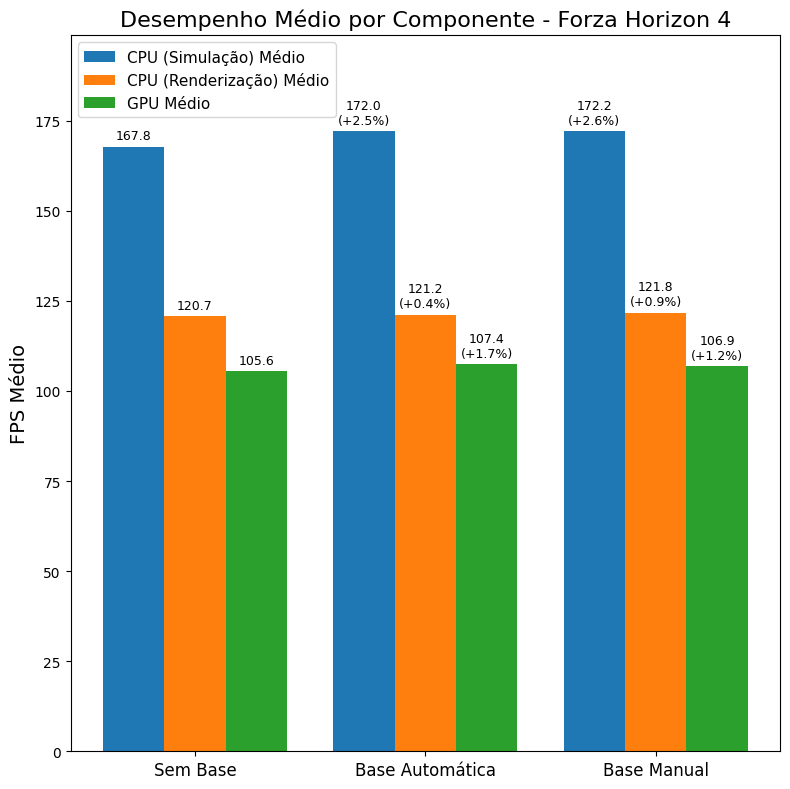

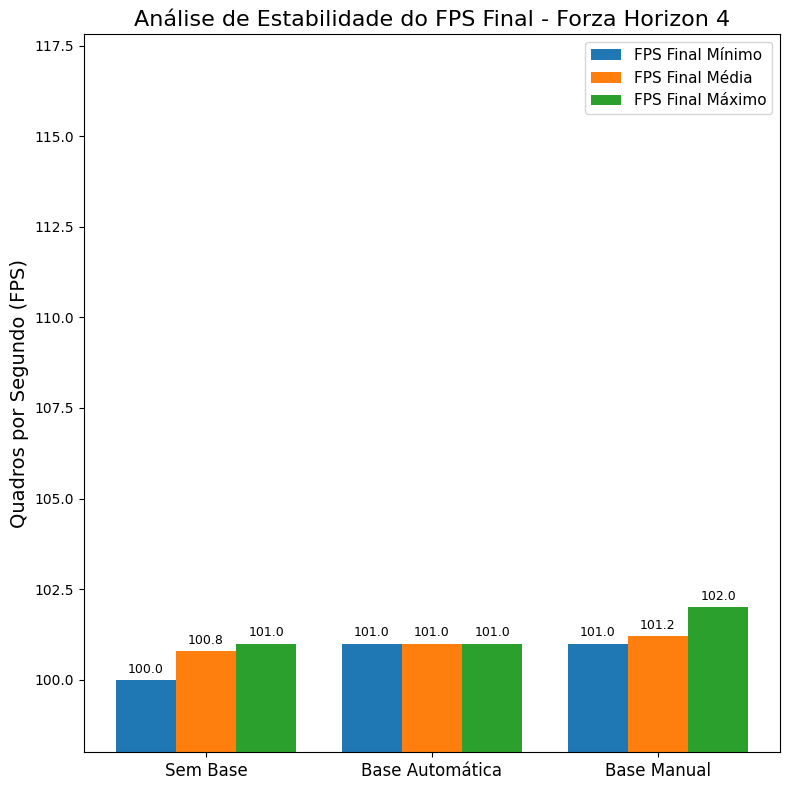

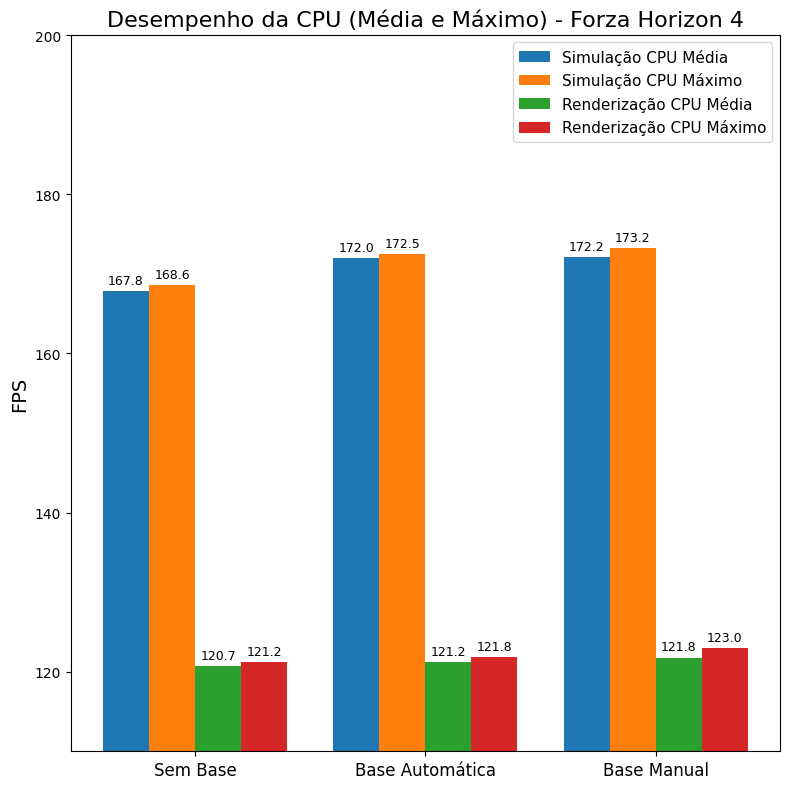

In [ ]:
import pandas as pd
import numpy as np

# Dados extraídos da imagem de teste do Forza Horizon 4
test_data = {
    'Sem Base': {
        'Simulação da CPU': [167.7, 168.6, 167.5, 167.3, 168],
        'Renderização da CPU': [120.8, 121.2, 120.2, 120.4, 121],
        'GPU': [105.4, 105.6, 105.4, 105.6, 105.9],
        'Fps Final': [101, 101, 100, 101, 101]
    },
    'Base Automática': {
        'Simulação da CPU': [171.9, 172, 172.4, 171.3, 172.5],
        'Renderização da CPU': [120.9, 121.2, 121.3, 120.7, 121.8],
        'GPU': [107.5, 107.4, 107.4, 107.5, 107.3],
        'Fps Final': [101, 101, 101, 101, 101]
    },
    'Base Manual': {
        'Simulação da CPU': [172.5, 171, 173.2, 172.9, 171.2],
        'Renderização da CPU': [121.7, 121, 123, 122.1, 121.1],
        'GPU': [106.9, 106.9, 106.8, 106.9, 106.9],
        'Fps Final': [101, 101, 102, 101, 101]
    }
}

# Lista para armazenar os dados processados
processed_data = []

# Iterar sobre os dados para calcular Min, Mean e Max
for base, metrics in test_data.items():
    row = {'Base': base}
    for metric_name, values in metrics.items():
        row[f'{metric_name}_Min'] = np.min(values)
        row[f'{metric_name}_Mean'] = np.mean(values)
        row[f'{metric_name}_Max'] = np.max(values)
    processed_data.append(row)

# Criar o DataFrame final, pronto para ser usado pela função de plotagem
summary_df_fh4 = pd.DataFrame(processed_data).set_index('Base')

print("DataFrame criado a partir dos dados de teste:")
print(summary_df_fh4)

# Chamando a função para plotar apenas a MÉDIA de cada componente
plot_metrics_flexible(
    df_summary=summary_df_fh4,
    metric_prefixes=['Simulação da CPU', 'Renderização da CPU', 'GPU'],
    stats_to_plot='Mean', # Apenas a média
    title='Desempenho Médio por Componente - Forza Horizon 4',
    ylabel='FPS Médio',
    # Renomeando para legendas mais limpas
    metric_prefixes_renamed=['CPU (Simulação)', 'CPU (Renderização)', 'GPU'],
    stats_renamed={'Mean': 'Médio'},
    show_diff_percent=True
)

# Chamando a função para analisar o FPS Final (Min, Mean, Max)
plot_metrics_flexible(
    df_summary=summary_df_fh4,
    metric_prefixes=['Fps Final'],
    stats_to_plot=['Min', 'Mean', 'Max'],
    title='Análise de Estabilidade do FPS Final - Forza Horizon 4',
    ylabel='Quadros por Segundo (FPS)',
    # Renomeando para legendas em português
    metric_prefixes_renamed=['FPS Final'],
    stats_renamed={'Min': 'Mínimo', 'Mean': 'Média', 'Max': 'Máximo'},
    y_min=98 # Dando "zoom" para ver melhor as pequenas diferenças
)

# Chamando a função para um comparativo detalhado da CPU
plot_metrics_flexible(
    df_summary=summary_df_fh4,
    metric_prefixes=['Simulação da CPU', 'Renderização da CPU'],
    stats_to_plot=['Mean', 'Max'],
    title='Desempenho da CPU (Média e Máximo) - Forza Horizon 4',
    ylabel='FPS',
    metric_prefixes_renamed=['Simulação CPU', 'Renderização CPU'],
    stats_renamed={'Mean': 'Média', 'Max': 'Máximo'},
    y_min=110
)

# Testes com vídeo em 4k

## Leitura e preparação do dataframe

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Configurações de visualização
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

In [ ]:
# Carregar os arquivos CSV (ajuste os caminhos caso necessário)
sem_base = pd.read_csv('data/4k/sem_base.csv')
base_manual = pd.read_csv('data/4k/base_manual.csv')
base_auto = pd.read_csv('data/4k/base_automatica.csv')

# Visualizar colunas para referência
print("Colunas disponíveis em sem_base:", sem_base.columns.tolist())
print("Colunas disponíveis em base_manual:", base_manual.columns.tolist())
print("Colunas disponíveis em base_auto:", base_auto.columns.tolist())

Colunas disponíveis em sem_base: ['Date', 'Virtual Memory Committed [MB]', 'Virtual Memory Available [MB]', 'Virtual Memory Load [%]', 'Physical Memory Used [MB]', 'Physical Memory Available [MB]', 'Physical Memory Load [%]', 'Page File Usage [%]', 'Core VIDs (avg) [V]', 'Core 0 VID [V]', 'Core 1 VID [V]', 'Core 2 VID [V]', 'Core 3 VID [V]', 'Core Clocks (avg) [MHz]', 'Core 0 Clock [MHz]', 'Core 1 Clock [MHz]', 'Core 2 Clock [MHz]', 'Core 3 Clock [MHz]', 'Bus Clock [MHz]', 'Ring/LLC Clock [MHz]', 'System Agent Clock [MHz]', 'Core Effective Clocks (avg) [MHz]', 'Core 0 T0 Effective Clock [MHz]', 'Core 0 T1 Effective Clock [MHz]', 'Core 1 T0 Effective Clock [MHz]', 'Core 1 T1 Effective Clock [MHz]', 'Core 2 T0 Effective Clock [MHz]', 'Core 2 T1 Effective Clock [MHz]', 'Core 3 T0 Effective Clock [MHz]', 'Core 3 T1 Effective Clock [MHz]', 'Average Effective Clock [MHz]', 'Core Usage (avg) [%]', 'Core 0 T0 Usage [%]', 'Core 0 T1 Usage [%]', 'Core 1 T0 Usage [%]', 'Core 1 T1 Usage [%]', 'Cor

In [ ]:
def mean_db(db_values):
    """
    Calcula a média correta de valores em Decibéis (dB).

    Args:
        db_values (pd.Series or list): Uma série ou lista de valores em dB.

    Returns:
        float: A média correta em dB.
    """
    # Converter dB para intensidade linear (Power Ratio)
    # A fórmula é Power_Ratio = 10^(dB/10)
    power_ratios = 10**(db_values / 10)

    # Calcular a média dos Power Ratios
    mean_power_ratio = power_ratios.mean()

    # Converter a média dos Power Ratios de volta para dB
    # A fórmula é dB = 10 * log10(Power_Ratio)
    # Evitar log de zero se a média for zero (caso todos os valores originais sejam muito baixos ou zero)
    if mean_power_ratio <= 0:
        return -np.inf # Retorna -infinito para representar um nível de ruído muito baixo/nulo
    else:
        return 10 * np.log10(mean_power_ratio)

# Exemplo de uso (substitua com seus dados reais)
# media_ruido_correta = mean_db(df_seu_teste[cols['Ruido_Fan']])
# print(f"Média correta do Ruído (dB): {media_ruido_correta:.2f}")

In [ ]:
# Filtrar apenas as linhas em que o teste estava em execução
sem_base_test = sem_base[sem_base['IsTestRunning'] == True]
base_manual_test = base_manual[base_manual['IsTestRunning'] == True]
base_auto_test = base_auto[base_auto['IsTestRunning'] == True]

print(f"Amostras em execução - Sem Base: {len(sem_base_test)}")
print(f"Amostras em execução - Base Manual: {len(base_manual_test)}")
print(f"Amostras em execução - Base Automática: {len(base_auto_test)}")

Amostras em execução - Sem Base: 1800
Amostras em execução - Base Manual: 1800
Amostras em execução - Base Automática: 1800


In [ ]:
# Dicionário com os nomes de colunas
# cols = {
#     'CPU_Temp': 'Core Temperatures (avg) [�C]',
#     'GPU_Temp': 'GPU Temperature [�C]',
#     'RPM': 'Velocidade Fan Base',
#     'FPS_Avg': 'Framerate Presented (avg) [FPS]',
#     'FPS_1%': 'Framerate Presented (1%) [FPS]',
#     'FrameTime': 'Frame Time Presented (avg) [ms]',
#     'Media_PC_Fan': 'Velocidade Fan PC',
#     'Diferenca_Fan_Abs': 'Diferença fan (abs)',
#     'Ruido_Fan': 'RuidoEstimadoPoly',
#     'Disk_Temperature': 'Drive Temperature [�C].2'
# }
cols = {
    'CPU_Temp': 'CPU Package [�C]',
    'GPU_Temp': 'GPU Temperature [�C]',
    'RPM': 'Velocidade Fan Base',
    'CPU_Core_Clocks': 'Core Clocks (avg) [MHz]',
    'CPU_Core_Usage': 'Core Usage (avg) [%]',
    'Gpu_Core_Clocks': 'GPU Core Clocks (avg) [MHz]',
    'Gpu_Core_Usage': 'GPU Core Load [%]',
    'Gpu_Core_Clock': 'GPU Clock [MHz].1',
    'Media_PC_Fan': 'Velocidade Fan PC',
    'Diferenca_Fan_Abs': 'Diferença fan (abs)',
    'Ruido_Fan': 'RuidoEstimadoPoly',
    'Disk_Temperature': 'Drive Temperature [�C].2'
}

# Função para resumir estatísticas
# def resumir(df):
#     return {
#         'CPU_Temp_Mean': df[cols['CPU_Temp']].mean(),
#         'CPU_Temp_Max': df[cols['CPU_Temp']].max(),
#         'CPU_Temp_Std': df[cols['CPU_Temp']].std(),
#         'GPU_Temp_Mean': df[cols['GPU_Temp']].mean(),
#         'GPU_Temp_Max': df[cols['GPU_Temp']].max(),
#         'GPU_Temp_Std': df[cols['GPU_Temp']].std(),
#         'RPM_Mean': df[cols['RPM']].mean(),
#         'RPM_Max': df[cols['RPM']].max(),
#         'RPM_Std': df[cols['RPM']].std(),
#         'FPS_Avg_Mean': df[cols['FPS_Avg']].mean(),
#         'FPS_Avg_Std': df[cols['FPS_Avg']].std(),
#         'FPS_1%_Mean': df[cols['FPS_1%']].mean(),
#         'FPS_1%_Std': df[cols['FPS_1%']].std(),
#         'FrameTime_Mean': df[cols['FrameTime']].mean(),
#         'FrameTime_Max': df[cols['FrameTime']].max(),
#         'FrameTime_Std': df[cols['FrameTime']].std(),
#         'Media_PC_Fan_Mean': df[cols['Media_PC_Fan']].mean(),
#         'Media_PC_Fan_Max': df[cols['Media_PC_Fan']].max(),
#         'Media_PC_Fan_Std': df[cols['Media_PC_Fan']].std(),
#         'Diferenca_Fan_Abs_Mean': df[cols['Diferenca_Fan_Abs']].mean(),
#         'Diferenca_Fan_Abs_Max': df[cols['Diferenca_Fan_Abs']].max(),
#         'Diferenca_Fan_Abs_Std': df[cols['Diferenca_Fan_Abs']].std(),
#         'Ruido_Fan_Mean': df[cols['Ruido_Fan']].mean(),
#         'Ruido_Fan_Max': df[cols['Ruido_Fan']].max(),
#         'Ruido_Fan_Std': df[cols['Ruido_Fan']].std(),
#         'Disk_Temperature_Mean': df[cols['Disk_Temperature']].mean(),
#         'Disk_Temperature_Max': df[cols['Disk_Temperature']].max(),
#         'Disk_Temperature_Std': df[cols['Disk_Temperature']].std()
#     }
def resumir(df):
    return {
        'CPU_Temp_Mean': df[cols['CPU_Temp']].mean(),
        'CPU_Temp_Max': df[cols['CPU_Temp']].max(),
        'CPU_Temp_Min': df[cols['CPU_Temp']].min(),
        'CPU_Temp_Std': df[cols['CPU_Temp']].std(),
        'GPU_Temp_Mean': df[cols['GPU_Temp']].mean(),
        'GPU_Temp_Max': df[cols['GPU_Temp']].max(),
        'GPU_Temp_Min': df[cols['GPU_Temp']].min(),
        'GPU_Temp_Std': df[cols['GPU_Temp']].std(),
        'RPM_Mean': df[cols['RPM']].mean(),
        'RPM_Max': df[cols['RPM']].max(),
        'RPM_Min': df[cols['RPM']].min(),
        'RPM_Std': df[cols['RPM']].std(),
        'Media_PC_Fan_Mean': df[cols['Media_PC_Fan']].mean(),
        'Media_PC_Fan_Max': df[cols['Media_PC_Fan']].max(),
        'Media_PC_Fan_Min': df[cols['Media_PC_Fan']].min(),
        'Media_PC_Fan_Std': df[cols['Media_PC_Fan']].std(),
        'Diferenca_Fan_Abs_Mean': df[cols['Diferenca_Fan_Abs']].mean(),
        'Diferenca_Fan_Abs_Max': df[cols['Diferenca_Fan_Abs']].max(),
        'Diferenca_Fan_Abs_Min': df[cols['Diferenca_Fan_Abs']].min(),
        'Diferenca_Fan_Abs_Std': df[cols['Diferenca_Fan_Abs']].std(),
        'Ruido_Fan_Mean': mean_db(df[cols['Ruido_Fan']]), # Usar mean_db para calcular a média do ruído
        'Ruido_Fan_Max': df[cols['Ruido_Fan']].max(),
        'Ruido_Fan_Min': df[cols['Ruido_Fan']].min(),
        'Ruido_Fan_Std': df[cols['Ruido_Fan']].std(),
        'Disk_Temperature_Mean': df[cols['Disk_Temperature']].mean(),
        'Disk_Temperature_Max': df[cols['Disk_Temperature']].max(),
        'Disk_Temperature_Min': df[cols['Disk_Temperature']].min(),
        'Disk_Temperature_Std': df[cols['Disk_Temperature']].std(),

        'CPU_Core_Clocks_Mean': df[cols['CPU_Core_Clocks']].mean(),
        'CPU_Core_Clocks_Max': df[cols['CPU_Core_Clocks']].max(),
        'CPU_Core_Clocks_Min': df[cols['CPU_Core_Clocks']].min(),
        'CPU_Core_Clocks_Std': df[cols['CPU_Core_Clocks']].std(),
        'CPU_Core_Usage_Mean': df[cols['CPU_Core_Usage']].mean(),
        'CPU_Core_Usage_Max': df[cols['CPU_Core_Usage']].max(),
        'CPU_Core_Usage_Min': df[cols['CPU_Core_Usage']].min(),
        'CPU_Core_Usage_Std': df[cols['CPU_Core_Usage']].std(),
        'Gpu_Core_Clocks_Mean': df[cols['Gpu_Core_Clock']].mean(),
        'Gpu_Core_Clocks_Max': df[cols['Gpu_Core_Clock']].max(),
        'Gpu_Core_Clocks_Min': df[cols['Gpu_Core_Clock']].min(),
        'Gpu_Core_Clocks_Std': df[cols['Gpu_Core_Clock']].std(),
        'Gpu_Core_Usage_Mean': df[cols['Gpu_Core_Usage']].mean(),
        'Gpu_Core_Usage_Max': df[cols['Gpu_Core_Usage']].max(),
        'Gpu_Core_Usage_Min': df[cols['Gpu_Core_Usage']].min(),
        'Gpu_Core_Usage_Std': df[cols['Gpu_Core_Usage']].std(),
        'Gpu_Core_Clock_Mean': df[cols['Gpu_Core_Clock']].mean(),
        'Gpu_Core_Clock_Max': df[cols['Gpu_Core_Clock']].max(),
        'Gpu_Core_Clock_Min': df[cols['Gpu_Core_Clock']].min(),
        'Gpu_Core_Clock_Std': df[cols['Gpu_Core_Clock']].std(),


        'Cpu_Package_Power_Mean': df['CPU Package Power [W]'].mean(),
        'Cpu_Package_Power_Max': df['CPU Package Power [W]'].max(),
        'Cpu_Package_Power_Min': df['CPU Package Power [W]'].min(),
        'Cpu_Package_Power_Std': df['CPU Package Power [W]'].std(),
    }

# Calcular resumos para cada cenário
summary_sem = resumir(sem_base_test)
summary_manual = resumir(base_manual_test)
summary_auto = resumir(base_auto_test)

# Montar DataFrame de resumo
summary_df = pd.DataFrame([
    summary_sem,
    summary_manual,
    summary_auto
], index=['Sem Base', 'Base Manual', 'Base Automática'])
summary_df = summary_df.round(2)
display(summary_df)

,CPU_Temp_Mean,CPU_Temp_Max,CPU_Temp_Min,CPU_Temp_Std,GPU_Temp_Mean,GPU_Temp_Max,GPU_Temp_Min,GPU_Temp_Std,RPM_Mean,RPM_Max,RPM_Min,RPM_Std,Media_PC_Fan_Mean,Media_PC_Fan_Max,Media_PC_Fan_Min,Media_PC_Fan_Std,Diferenca_Fan_Abs_Mean,Diferenca_Fan_Abs_Max,Diferenca_Fan_Abs_Min,Diferenca_Fan_Abs_Std,Ruido_Fan_Mean,Ruido_Fan_Max,Ruido_Fan_Min,Ruido_Fan_Std,Disk_Temperature_Mean,Disk_Temperature_Max,Disk_Temperature_Min,Disk_Temperature_Std,CPU_Core_Clocks_Mean,CPU_Core_Clocks_Max,CPU_Core_Clocks_Min,CPU_Core_Clocks_Std,CPU_Core_Usage_Mean,CPU_Core_Usage_Max,CPU_Core_Usage_Min,CPU_Core_Usage_Std,Gpu_Core_Clocks_Mean,Gpu_Core_Clocks_Max,Gpu_Core_Clocks_Min,Gpu_Core_Clocks_Std,Gpu_Core_Usage_Mean,Gpu_Core_Usage_Max,Gpu_Core_Usage_Min,Gpu_Core_Usage_Std,Gpu_Core_Clock_Mean,Gpu_Core_Clock_Max,Gpu_Core_Clock_Min,Gpu_Core_Clock_Std,Cpu_Package_Power_Mean,Cpu_Package_Power_Max,Cpu_Package_Power_Min,Cpu_Package_Power_Std
Sem Base,51.40,71,46,3.57,45.59,47.6,42.3,1.30,0.00,0,0,0.00,2185.10,2361.5,2068.5,91.26,97.62,234,30,55.39,36.84,38.05,35.97,0.65,36.89,39,34,1.28,2833.45,3994.2,2391.8,654.32,11.38,40.7,2.4,5.85,540.0,540.0,540.0,0.0,0.0,0.0,0.0,0.0,540.0,540.0,540.0,0.0,14.53,37.44,9.60,3.54
Base Manual,37.82,57,35,2.42,33.52,35.0,32.8,0.40,2257.95,2280,2250,13.24,2127.59,2151.0,2113.5,8.04,112.11,137,90,9.00,62.80,63.26,62.58,0.27,32.63,35,32,0.86,2636.16,3994.2,2391.2,541.50,11.74,46.7,2.6,6.41,300.0,300.0,300.0,0.0,0.0,0.0,0.0,0.0,300.0,300.0,300.0,0.0,14.70,35.80,10.75,3.22
Base Automática,44.80,60,42,2.87,39.45,40.4,38.9,0.22,594.08,1200,420,92.33,2079.26,2132.5,2048.5,24.55,116.61,225,70,49.27,38.53,44.67,37.16,0.77,36.93,37,36,0.26,2813.74,3994.2,2391.8,660.11,12.12,41.5,3.2,6.31,300.0,300.0,300.0,0.0,0.0,0.0,0.0,0.0,300.0,300.0,300.0,0.0,14.39,34.55,10.14,3.39


In [ ]:
# Converter colunas de flag (Yes/No) em binário e calcular eventos e percentuais
flags = [
    'Core Thermal Throttling (avg) [Yes/No]',
    'Core Critical Temperature (avg) [Yes/No]',
    'Package/Ring Thermal Throttling [Yes/No]',
    'Package/Ring Critical Temperature [Yes/No]'
]

def calcular_flags(df, nome_cenario):
    resultados = {}
    total = len(df)
    for f in flags:
        if f in df.columns:
            # Mapear Yes->1, No->0
            bin_col = df[f].map({'Yes': 1, 'No': 0})
            soma = bin_col.sum()
            perc = soma / total * 100
            resultados[f"{f} #eventos"] = int(soma)
            resultados[f"{f} %tempo"] = round(perc, 2)
        else:
            resultados[f"{f} #eventos"] = None
            resultados[f"{f} %tempo"] = None
    return pd.Series(resultados, name=nome_cenario)

# Gerar tabelas de flags para cada cenário
flags_sem = calcular_flags(sem_base_test, 'Sem Base')
flags_manual = calcular_flags(base_manual_test, 'Base Manual')
flags_auto = calcular_flags(base_auto_test, 'Base Automática')

df_flags = pd.DataFrame([flags_sem, flags_manual, flags_auto])
display(df_flags)

,Core Thermal Throttling (avg) [Yes/No] #eventos,Core Thermal Throttling (avg) [Yes/No] %tempo,Core Critical Temperature (avg) [Yes/No] #eventos,Core Critical Temperature (avg) [Yes/No] %tempo,Package/Ring Thermal Throttling [Yes/No] #eventos,Package/Ring Thermal Throttling [Yes/No] %tempo,Package/Ring Critical Temperature [Yes/No] #eventos,Package/Ring Critical Temperature [Yes/No] %tempo
Sem Base,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Manual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Automática,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Cálculo de métricas de potência (W) para CPU e GPU, se as colunas existirem
power_cols = {
    'CPU': ['CPU Package Power [W]', 'CPU Package Power'],
    'GPU': ['GPU Power [W]', 'GPU Power']
}

def resumir_potencia(df, prefix):
    resultados = {}
    for comp, poss_names in power_cols.items():
        # Encontrar o nome exato da coluna
        col_existe = next((c for c in poss_names if c in df.columns), None)
        if col_existe:
            resultados[f"{comp}_Power_Mean (W)"] = df[col_existe].mean()
            resultados[f"{comp}_Power_Std (W)"] = df[col_existe].std()
            resultados[f"{comp}_Power_Max (W)"] = df[col_existe].max()
        else:
            resultados[f"{comp}_Power_Mean (W)"] = None
            resultados[f"{comp}_Power_Std (W)"] = None
            resultados[f"{comp}_Power_Max (W)"] = None
    return pd.Series(resultados, name=prefix)

# Calcular para cada cenário
power_sem = resumir_potencia(sem_base_test, 'Sem Base')
power_manual = resumir_potencia(base_manual_test, 'Base Manual')
power_auto = resumir_potencia(base_auto_test, 'Base Automática')

df_power = pd.DataFrame([power_sem, power_manual, power_auto])
display(df_power)

,CPU_Power_Mean (W),CPU_Power_Std (W),CPU_Power_Max (W),GPU_Power_Mean (W),GPU_Power_Std (W),GPU_Power_Max (W)
Sem Base,14.525723,3.542260,37.444,1.078824,0.038161,1.249
Base Manual,14.704957,3.224277,35.795,1.068734,0.039217,1.278
Base Automática,14.393602,3.385470,34.552,1.070407,0.035593,1.216


## Gráficos

In [ ]:
# plot_min_max_mean(summary_df, 'CPU_Temp', 'Comparativo de Temperatura da CPU', 'Temperatura (°C)', ymin=30)

# plot_min_max_mean(summary_df, 'GPU_Temp', 'Comparativo de Temperatura da GPU', 'Temperatura (°C)', ymin=30)

# plot_min_max_mean(summary_df, 'RPM', 'Comparativo de Velocidade da Fan da Base', 'RPM')

# plot_min_max_mean(summary_df, 'Media_PC_Fan', 'Comparativo de Velocidade da Fan da PC', 'RPM')

# plot_min_max_mean(summary_df, 'Ruido_Fan', 'Comparativo de Ruido da Fan', 'Db')

# plot_min_max_mean(summary_df, 'CPU_Core_Clocks', 'Comparativo de Clock da CPU', 'MHz')

# plot_min_max_mean(summary_df, 'CPU_Core_Usage', 'Comparativo de Uso da CPU', '%')

# plot_min_max_mean(summary_df, 'Gpu_Core_Usage', 'Comparativo de Uso da GPU', '%')

# plot_min_max_mean(summary_df, 'Gpu_Core_Clock', 'Comparativo de Clock da GPU', 'MHz')


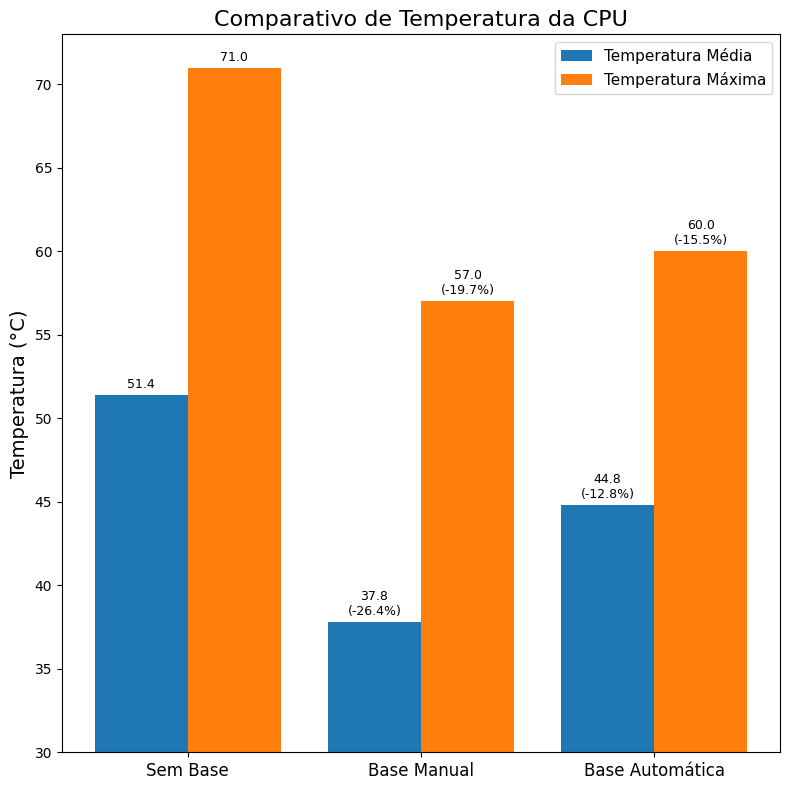

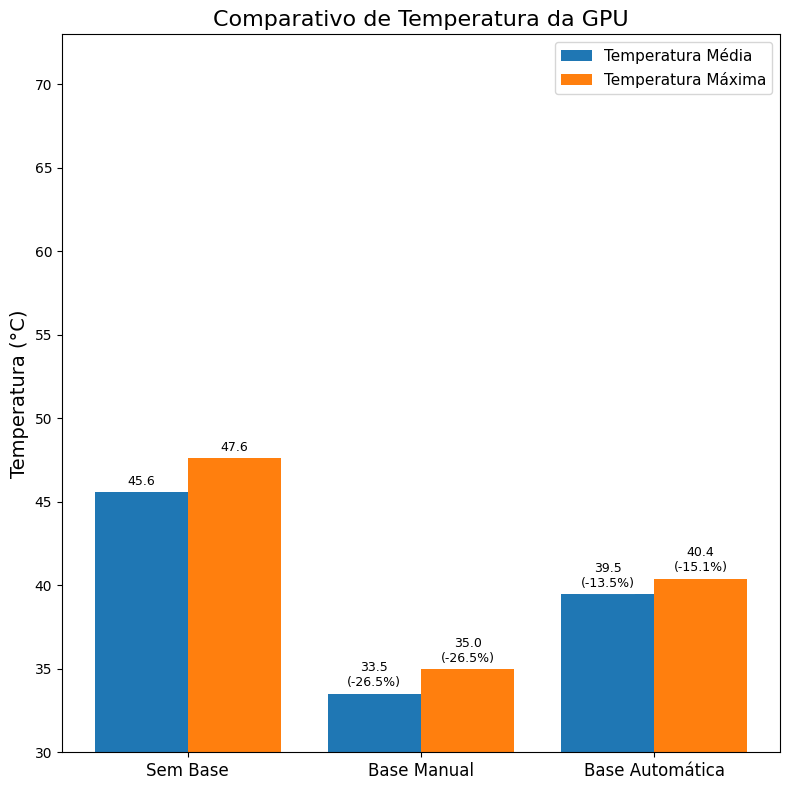

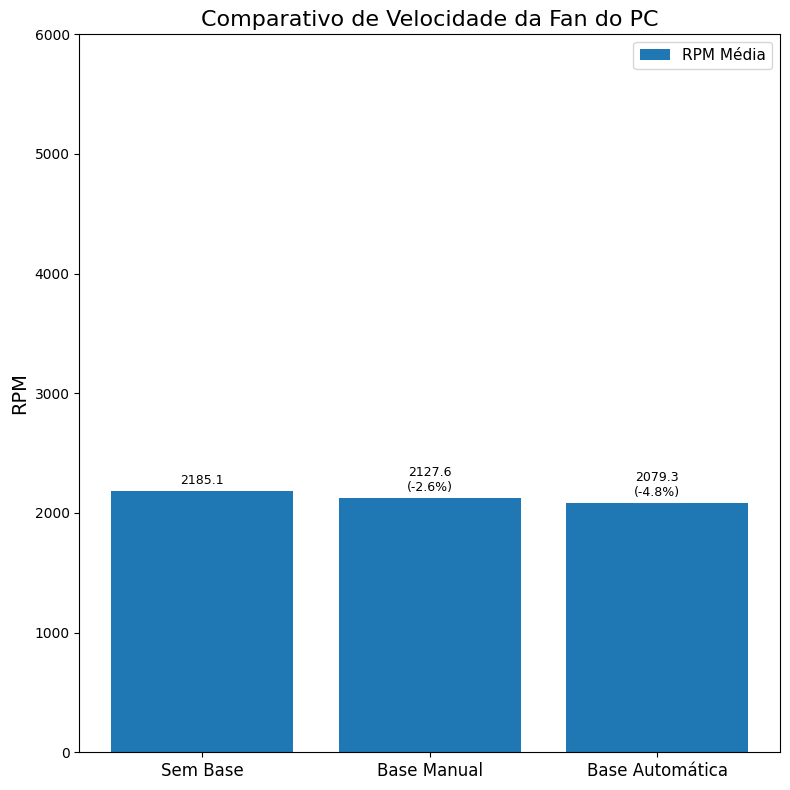

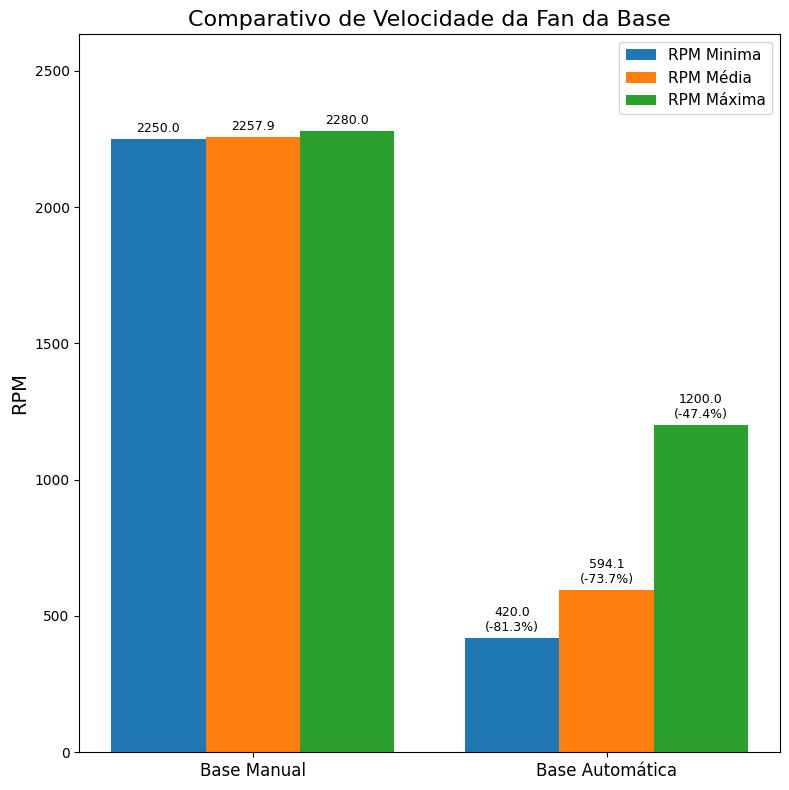

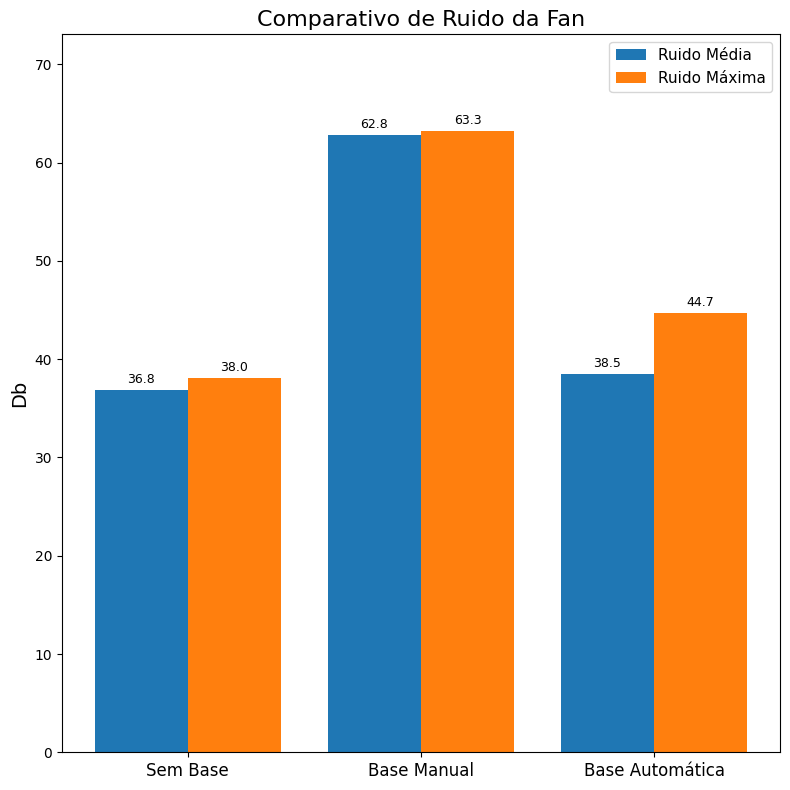

In [ ]:
# plot_max_mean(summary_df, 'CPU_Temp', 'Comparativo de Temperatura da CPU', 'Temperatura (°C)', ymin=30, metric_prefixes_renamed=['Temperatura'])
# plot_max_mean(summary_df, 'GPU_Temp', 'Comparativo de Temperatura da GPU', 'Temperatura (°C)', ymin=30, metric_prefixes_renamed=['Temperatura'])
# plot_max_mean(summary_df, 'GPU_Hotspot_temp', 'Comparativo de Temperatura do hot spot da GPU', 'Temperatura (°C)', ymin=30)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='CPU_Temp',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Temperatura da CPU',
    ylabel='Temperatura (°C)',
    metric_prefixes_renamed=['Temperatura'],
    stats_renamed={'Mean': 'Média', 'Max': 'Máxima'},
    y_min=30,
    y_max=73,
    show_diff_percent=True
)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='GPU_Temp',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Temperatura da GPU',
    ylabel='Temperatura (°C)',
    metric_prefixes_renamed=['Temperatura'],
    stats_renamed={'Mean': 'Média', 'Max': 'Máxima'},
    y_min=30,
    y_max=73,
    show_diff_percent=True
)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='Media_PC_Fan',
    stats_to_plot=['Mean'], # Duas estatísticas
    title='Comparativo de Velocidade da Fan do PC',
    ylabel='RPM',
    metric_prefixes_renamed=['RPM'],
    stats_renamed={'Mean': 'Média', 'Max': 'Máxima'},
    show_diff_percent=True,
    y_max=6000
)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='RPM',
    stats_to_plot=['Min','Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Velocidade da Fan da Base',
    ylabel='RPM',
    metric_prefixes_renamed=['RPM'],
    stats_renamed={'Min':'Minima','Mean': 'Média', 'Max': 'Máxima'},
    show_diff_percent=True
)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='Ruido_Fan',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Ruido da Fan',
    ylabel='Db',
    metric_prefixes_renamed=['Ruido'],
    stats_renamed={'Mean': 'Média', 'Max': 'Máxima'},
    show_diff_percent=False
)



# plot_metrics_flexible(
#     df_summary=summary_df,
#     metric_prefixes='Cpu_Package_Power',
#     stats_to_plot='Mean', # Duas estatísticas
#     title='Comparativo de Potência da CPU',
#     ylabel='Potência (W)',
#     metric_prefixes_renamed=['Potência'],
#     y_min=30
# )

# Testes com Forza Horizon 4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Configurações de visualização
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

In [ ]:
# Carregar os arquivos CSV (ajuste os caminhos caso necessário)
sem_base = pd.read_csv('data/FH4/sem_base.csv')
base_manual = pd.read_csv('data/FH4/base_manual.csv')
base_auto = pd.read_csv('data/FH4/base_automatica.csv')

# Visualizar colunas para referência
print("Colunas disponíveis em sem_base:", sem_base.columns.tolist())
print("Colunas disponíveis em base_manual:", base_manual.columns.tolist())
print("Colunas disponíveis em base_auto:", base_auto.columns.tolist())

Colunas disponíveis em sem_base: ['Date', 'Virtual Memory Committed [MB]', 'Virtual Memory Available [MB]', 'Virtual Memory Load [%]', 'Physical Memory Used [MB]', 'Physical Memory Available [MB]', 'Physical Memory Load [%]', 'Page File Usage [%]', 'Core VIDs (avg) [V]', 'Core 0 VID [V]', 'Core 1 VID [V]', 'Core 2 VID [V]', 'Core 3 VID [V]', 'Core Clocks (avg) [MHz]', 'Core 0 Clock [MHz]', 'Core 1 Clock [MHz]', 'Core 2 Clock [MHz]', 'Core 3 Clock [MHz]', 'Bus Clock [MHz]', 'Ring/LLC Clock [MHz]', 'System Agent Clock [MHz]', 'Core Effective Clocks (avg) [MHz]', 'Core 0 T0 Effective Clock [MHz]', 'Core 0 T1 Effective Clock [MHz]', 'Core 1 T0 Effective Clock [MHz]', 'Core 1 T1 Effective Clock [MHz]', 'Core 2 T0 Effective Clock [MHz]', 'Core 2 T1 Effective Clock [MHz]', 'Core 3 T0 Effective Clock [MHz]', 'Core 3 T1 Effective Clock [MHz]', 'Average Effective Clock [MHz]', 'Core Usage (avg) [%]', 'Core 0 T0 Usage [%]', 'Core 0 T1 Usage [%]', 'Core 1 T0 Usage [%]', 'Core 1 T1 Usage [%]', 'Cor

In [ ]:
# Filtrar apenas as linhas em que o teste estava em execução
sem_base_test = sem_base[sem_base['IsTestRunning'] == True]
base_manual_test = base_manual[base_manual['IsTestRunning'] == True]
base_auto_test = base_auto[base_auto['IsTestRunning'] == True]

print(f"Amostras em execução - Sem Base: {len(sem_base_test)}")
print(f"Amostras em execução - Base Manual: {len(base_manual_test)}")
print(f"Amostras em execução - Base Automática: {len(base_auto_test)}")

Amostras em execução - Sem Base: 460
Amostras em execução - Base Manual: 460
Amostras em execução - Base Automática: 460


In [ ]:
# Dicionário com os nomes de colunas
# cols = {
#     'CPU_Temp': 'Core Temperatures (avg) [�C]',
#     'GPU_Temp': 'GPU Temperature [�C]',
#     'RPM': 'Velocidade Fan Base',
#     'FPS_Avg': 'Framerate Presented (avg) [FPS]',
#     'FPS_1%': 'Framerate Presented (1%) [FPS]',
#     'FrameTime': 'Frame Time Presented (avg) [ms]',
#     'Media_PC_Fan': 'Velocidade Fan PC',
#     'Diferenca_Fan_Abs': 'Diferença fan (abs)',
#     'Ruido_Fan': 'RuidoEstimadoPoly',
#     'Disk_Temperature': 'Drive Temperature [�C].2'
# }
cols = {
    'CPU_Temp': 'CPU Package [�C]',
    'GPU_Temp': 'GPU Temperature [�C]',
    'GPU_Hotspot_temp': 'GPU Hot Spot Temperature [�C]',
    'RPM': 'Velocidade Fan Base',
    'CPU_Core_Clocks': 'Core Clocks (avg) [MHz]',
    'CPU_Core_Usage': 'Core Usage (avg) [%]',
    'Gpu_Core_Clocks': 'GPU Core Clocks (avg) [MHz]',
    'Gpu_Core_Usage': 'GPU Core Load [%]',
    'Gpu_Core_Clock': 'GPU Clock [MHz].1',
    'Media_PC_Fan': 'Velocidade Fan PC',
    'Diferenca_Fan_Abs': 'Diferença fan (abs)',
    'Ruido_Fan': 'RuidoEstimadoPoly',
    'Disk_Temperature': 'Drive Temperature [�C].2',
    'Cpu_Package_Power': 'CPU Package Power [W]'
}

# Função para resumir estatísticas
# def resumir(df):
#     return {
#         'CPU_Temp_Mean': df[cols['CPU_Temp']].mean(),
#         'CPU_Temp_Max': df[cols['CPU_Temp']].max(),
#         'CPU_Temp_Std': df[cols['CPU_Temp']].std(),
#         'GPU_Temp_Mean': df[cols['GPU_Temp']].mean(),
#         'GPU_Temp_Max': df[cols['GPU_Temp']].max(),
#         'GPU_Temp_Std': df[cols['GPU_Temp']].std(),
#         'RPM_Mean': df[cols['RPM']].mean(),
#         'RPM_Max': df[cols['RPM']].max(),
#         'RPM_Std': df[cols['RPM']].std(),
#         'FPS_Avg_Mean': df[cols['FPS_Avg']].mean(),
#         'FPS_Avg_Std': df[cols['FPS_Avg']].std(),
#         'FPS_1%_Mean': df[cols['FPS_1%']].mean(),
#         'FPS_1%_Std': df[cols['FPS_1%']].std(),
#         'FrameTime_Mean': df[cols['FrameTime']].mean(),
#         'FrameTime_Max': df[cols['FrameTime']].max(),
#         'FrameTime_Std': df[cols['FrameTime']].std(),
#         'Media_PC_Fan_Mean': df[cols['Media_PC_Fan']].mean(),
#         'Media_PC_Fan_Max': df[cols['Media_PC_Fan']].max(),
#         'Media_PC_Fan_Std': df[cols['Media_PC_Fan']].std(),
#         'Diferenca_Fan_Abs_Mean': df[cols['Diferenca_Fan_Abs']].mean(),
#         'Diferenca_Fan_Abs_Max': df[cols['Diferenca_Fan_Abs']].max(),
#         'Diferenca_Fan_Abs_Std': df[cols['Diferenca_Fan_Abs']].std(),
#         'Ruido_Fan_Mean': df[cols['Ruido_Fan']].mean(),
#         'Ruido_Fan_Max': df[cols['Ruido_Fan']].max(),
#         'Ruido_Fan_Std': df[cols['Ruido_Fan']].std(),
#         'Disk_Temperature_Mean': df[cols['Disk_Temperature']].mean(),
#         'Disk_Temperature_Max': df[cols['Disk_Temperature']].max(),
#         'Disk_Temperature_Std': df[cols['Disk_Temperature']].std()
#     }
def resumir(df):
    return {
        'CPU_Temp_Mean': df[cols['CPU_Temp']].mean(),
        'CPU_Temp_Max': df[cols['CPU_Temp']].max(),
        'CPU_Temp_Min': df[cols['CPU_Temp']].min(),
        'CPU_Temp_Std': df[cols['CPU_Temp']].std(),
        'GPU_Temp_Mean': df[cols['GPU_Temp']].mean(),
        'GPU_Temp_Max': df[cols['GPU_Temp']].max(),
        'GPU_Temp_Min': df[cols['GPU_Temp']].min(),
        'GPU_Temp_Std': df[cols['GPU_Temp']].std(),
        'RPM_Mean': df[cols['RPM']].mean(),
        'RPM_Max': df[cols['RPM']].max(),
        'RPM_Min': df[cols['RPM']].min(),
        'RPM_Std': df[cols['RPM']].std(),
        'Media_PC_Fan_Mean': df[cols['Media_PC_Fan']].mean(),
        'Media_PC_Fan_Max': df[cols['Media_PC_Fan']].max(),
        'Media_PC_Fan_Min': df[cols['Media_PC_Fan']].min(),
        'Media_PC_Fan_Std': df[cols['Media_PC_Fan']].std(),
        'Diferenca_Fan_Abs_Mean': df[cols['Diferenca_Fan_Abs']].mean(),
        'Diferenca_Fan_Abs_Max': df[cols['Diferenca_Fan_Abs']].max(),
        'Diferenca_Fan_Abs_Min': df[cols['Diferenca_Fan_Abs']].min(),
        'Diferenca_Fan_Abs_Std': df[cols['Diferenca_Fan_Abs']].std(),
        'Ruido_Fan_Mean': mean_db(df[cols['Ruido_Fan']]),
        'Ruido_Fan_Max': df[cols['Ruido_Fan']].max(),
        'Ruido_Fan_Min': df[cols['Ruido_Fan']].min(),
        'Ruido_Fan_Std': df[cols['Ruido_Fan']].std(),
        'Disk_Temperature_Mean': df[cols['Disk_Temperature']].mean(),
        'Disk_Temperature_Max': df[cols['Disk_Temperature']].max(),
        'Disk_Temperature_Min': df[cols['Disk_Temperature']].min(),
        'Disk_Temperature_Std': df[cols['Disk_Temperature']].std(),

        'GPU_Hotspot_temp_Mean': df[cols['GPU_Hotspot_temp']].mean(),
        'GPU_Hotspot_temp_Max': df[cols['GPU_Hotspot_temp']].max(),
        'GPU_Hotspot_temp_Min': df[cols['GPU_Hotspot_temp']].min(),
        'GPU_Hotspot_temp_Std': df[cols['GPU_Hotspot_temp']].std(),

        'CPU_Core_Clocks_Mean': df[cols['CPU_Core_Clocks']].mean(),
        'CPU_Core_Clocks_Max': df[cols['CPU_Core_Clocks']].max(),
        'CPU_Core_Clocks_Min': df[cols['CPU_Core_Clocks']].min(),
        'CPU_Core_Clocks_Std': df[cols['CPU_Core_Clocks']].std(),
        'CPU_Core_Usage_Mean': df[cols['CPU_Core_Usage']].mean(),
        'CPU_Core_Usage_Max': df[cols['CPU_Core_Usage']].max(),
        'CPU_Core_Usage_Min': df[cols['CPU_Core_Usage']].min(),
        'CPU_Core_Usage_Std': df[cols['CPU_Core_Usage']].std(),
        'Gpu_Core_Clocks_Mean': df[cols['Gpu_Core_Clock']].mean(),
        'Gpu_Core_Clocks_Max': df[cols['Gpu_Core_Clock']].max(),
        'Gpu_Core_Clocks_Min': df[cols['Gpu_Core_Clock']].min(),
        'Gpu_Core_Clocks_Std': df[cols['Gpu_Core_Clock']].std(),
        'Gpu_Core_Usage_Mean': df[cols['Gpu_Core_Usage']].mean(),
        'Gpu_Core_Usage_Max': df[cols['Gpu_Core_Usage']].max(),
        'Gpu_Core_Usage_Min': df[cols['Gpu_Core_Usage']].min(),
        'Gpu_Core_Usage_Std': df[cols['Gpu_Core_Usage']].std(),
        'Gpu_Core_Clock_Mean': df[cols['Gpu_Core_Clock']].mean(),
        'Gpu_Core_Clock_Max': df[cols['Gpu_Core_Clock']].max(),
        'Gpu_Core_Clock_Min': df[cols['Gpu_Core_Clock']].min(),
        'Gpu_Core_Clock_Std': df[cols['Gpu_Core_Clock']].std(),

        'Cpu_Package_Power_Mean': df[cols['Cpu_Package_Power']].mean(),
        'Cpu_Package_Power_Max': df[cols['Cpu_Package_Power']].max(),
        'Cpu_Package_Power_Min': df[cols['Cpu_Package_Power']].min(),
        'Cpu_Package_Power_Std': df[cols['Cpu_Package_Power']].std(),
    }

# Calcular resumos para cada cenário
summary_sem = resumir(sem_base_test)
summary_manual = resumir(base_manual_test)
summary_auto = resumir(base_auto_test)

# Montar DataFrame de resumo
summary_df = pd.DataFrame([
    summary_sem,
    summary_manual,
    summary_auto
], index=['Sem Base', 'Base Manual', 'Base Automática'])
summary_df = summary_df.round(2)
display(summary_df)

,CPU_Temp_Mean,CPU_Temp_Max,CPU_Temp_Min,CPU_Temp_Std,GPU_Temp_Mean,GPU_Temp_Max,GPU_Temp_Min,GPU_Temp_Std,RPM_Mean,RPM_Max,RPM_Min,RPM_Std,Media_PC_Fan_Mean,Media_PC_Fan_Max,Media_PC_Fan_Min,Media_PC_Fan_Std,Diferenca_Fan_Abs_Mean,Diferenca_Fan_Abs_Max,Diferenca_Fan_Abs_Min,Diferenca_Fan_Abs_Std,Ruido_Fan_Mean,Ruido_Fan_Max,Ruido_Fan_Min,Ruido_Fan_Std,Disk_Temperature_Mean,Disk_Temperature_Max,Disk_Temperature_Min,Disk_Temperature_Std,GPU_Hotspot_temp_Mean,GPU_Hotspot_temp_Max,GPU_Hotspot_temp_Min,GPU_Hotspot_temp_Std,CPU_Core_Clocks_Mean,CPU_Core_Clocks_Max,CPU_Core_Clocks_Min,CPU_Core_Clocks_Std,CPU_Core_Usage_Mean,CPU_Core_Usage_Max,CPU_Core_Usage_Min,CPU_Core_Usage_Std,Gpu_Core_Clocks_Mean,Gpu_Core_Clocks_Max,Gpu_Core_Clocks_Min,Gpu_Core_Clocks_Std,Gpu_Core_Usage_Mean,Gpu_Core_Usage_Max,Gpu_Core_Usage_Min,Gpu_Core_Usage_Std,Gpu_Core_Clock_Mean,Gpu_Core_Clock_Max,Gpu_Core_Clock_Min,Gpu_Core_Clock_Std,Cpu_Package_Power_Mean,Cpu_Package_Power_Max,Cpu_Package_Power_Min,Cpu_Package_Power_Std
Sem Base,89.59,94,79,2.56,69.53,70.3,66.2,0.50,0.00,0,0,0.00,5400.45,5456.0,5358.5,16.65,110.61,292,97,34.52,58.13,58.38,57.93,0.08,38.69,40,38,0.47,79.76,80.6,76.0,0.53,3738.68,3993.2,2395.3,181.34,69.58,98.5,31.5,8.91,1797.33,1860.0,1590.0,22.13,96.47,100.0,35.0,7.53,1797.33,1860.0,1590.0,22.13,36.38,44.94,23.54,3.59
Base Manual,83.43,90,70,2.68,59.43,60.2,55.6,0.41,2243.61,2250,2220,12.30,4237.51,4321.5,4197.0,27.40,175.74,368,119,54.15,62.16,62.32,61.85,0.14,41.00,42,40,0.07,70.03,71.0,65.5,0.46,3883.66,3994.2,2394.7,191.18,70.52,96.0,27.3,8.57,1839.65,1890.0,1500.0,25.68,96.10,100.0,34.0,7.83,1839.65,1890.0,1500.0,25.68,38.54,44.90,26.59,3.49
Base Automática,82.22,89,71,3.22,58.87,59.4,54.1,0.48,2119.24,2250,1950,46.98,4879.95,4880.5,4830.5,4.84,237.89,239,139,9.69,61.92,63.00,60.55,0.39,41.84,43,41,0.37,69.11,69.9,63.6,0.56,3868.35,3993.2,2493.3,234.00,70.60,97.6,27.1,9.59,1838.18,1890.0,1545.0,30.10,96.11,100.0,37.0,7.40,1838.18,1890.0,1545.0,30.10,38.38,44.76,22.47,4.01


In [ ]:
# plot_min_max_mean(summary_df, 'CPU_Temp', 'Comparativo de Temperatura da CPU', 'Temperatura (°C)')

# plot_min_max_mean(summary_df, 'GPU_Temp', 'Comparativo de Temperatura da GPU', 'Temperatura (°C)')

# plot_min_max_mean(summary_df, 'GPU_Hotspot_temp', 'Comparativo de Temperatura do hot spot da GPU', 'Temperatura (°C)')

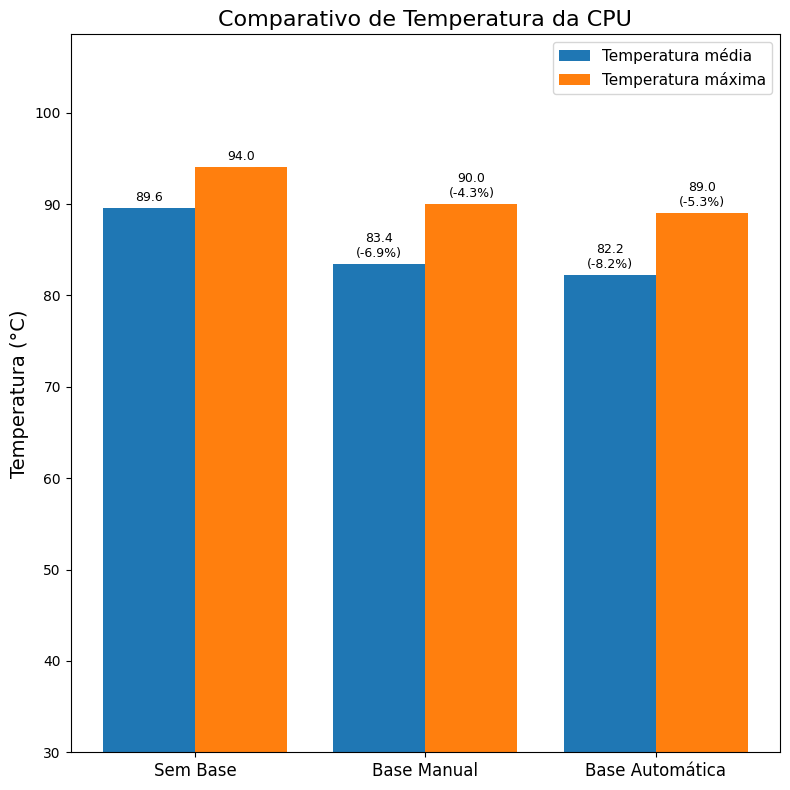

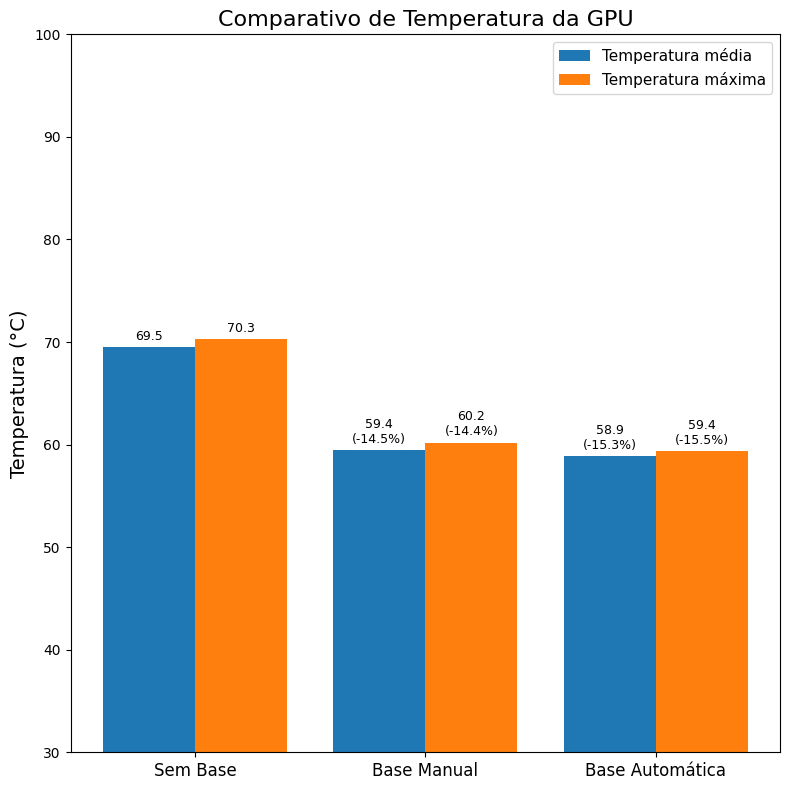

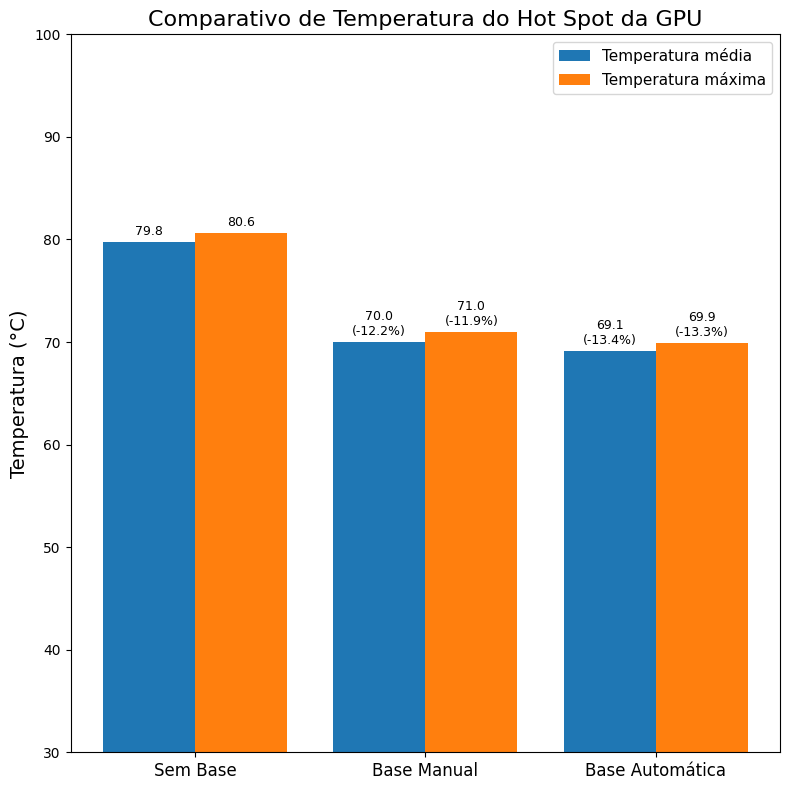

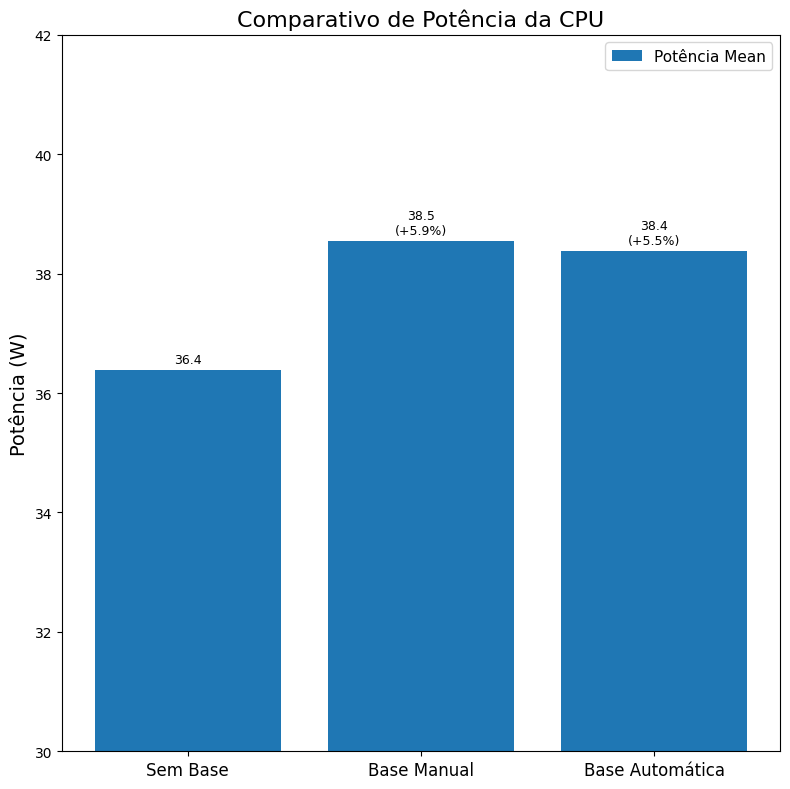

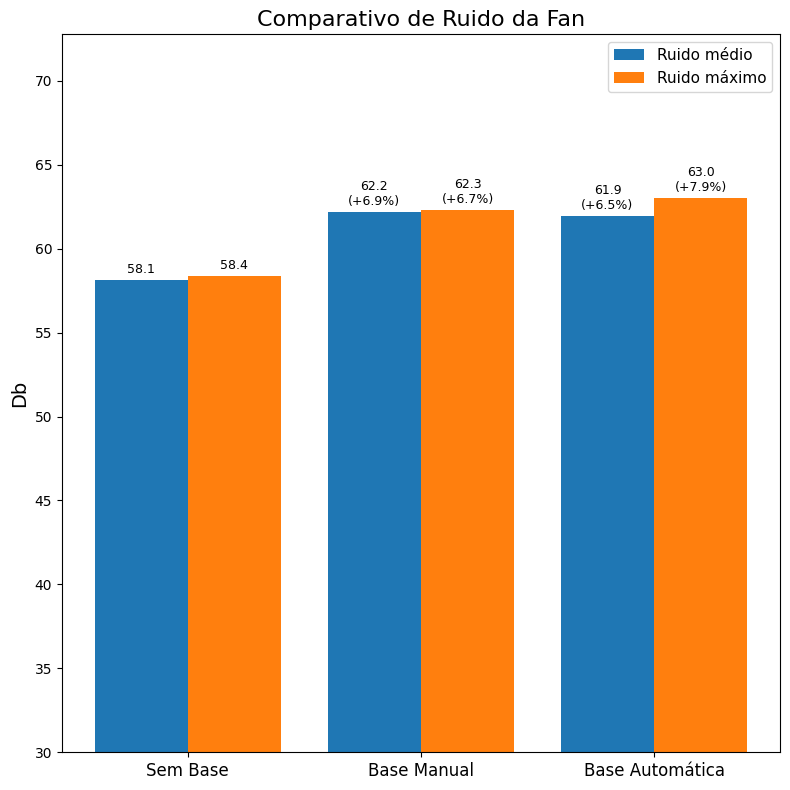

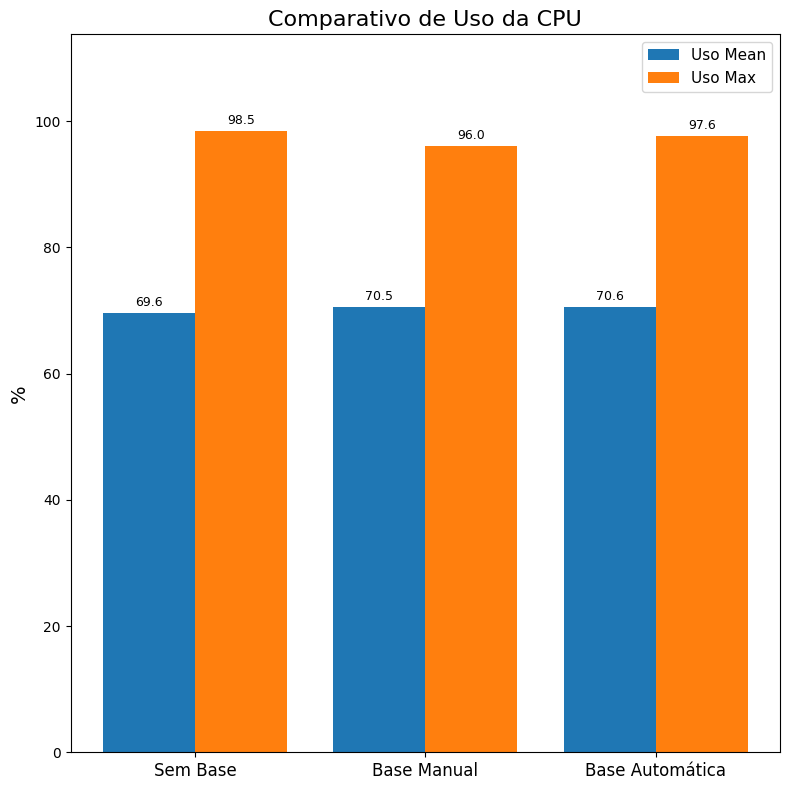

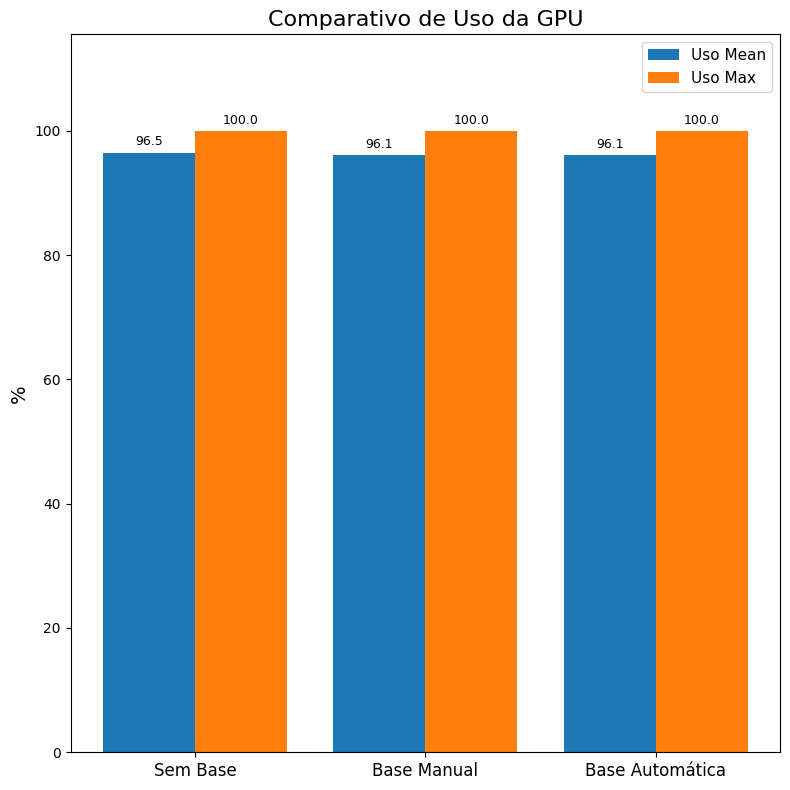

In [ ]:
# plot_max_mean(summary_df, 'CPU_Temp', 'Comparativo de Temperatura da CPU', 'Temperatura (°C)', ymin=30, ymax=100, metric_prefixes_renamed=['Temperatura'])
# plot_max_mean(summary_df, 'GPU_Temp', 'Comparativo de Temperatura da GPU', 'Temperatura (°C)', ymin=30, ymax=100, metric_prefixes_renamed=['Temperatura'])
# plot_max_mean(summary_df, 'GPU_Hotspot_temp', 'Comparativo de Temperatura do Hot Spot da GPU', 'Temperatura (°C)', ymin=30, metric_prefixes_renamed=['Temperatura'])
# plot_mean(summary_df, 'Cpu_Package_Power', 'Comparativo de Potência da CPU', 'W', metric_prefixes_renamed=['Potência'])
plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='CPU_Temp',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Temperatura da CPU',
    ylabel='Temperatura (°C)',
    metric_prefixes_renamed=['Temperatura'],
    stats_renamed={'Mean': 'média', 'Max': 'máxima'},
    y_min=30,
    show_diff_percent=True
)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='GPU_Temp',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Temperatura da GPU',
    ylabel='Temperatura (°C)',
    metric_prefixes_renamed=['Temperatura'],
    stats_renamed={'Mean': 'média', 'Max': 'máxima'},
    y_min=30,
    y_max=100,
    show_diff_percent=True
)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='GPU_Hotspot_temp',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Temperatura do Hot Spot da GPU',
    ylabel='Temperatura (°C)',
    metric_prefixes_renamed=['Temperatura'],
    stats_renamed={'Mean': 'média', 'Max': 'máxima'},
    y_min=30,
    y_max=100,
    show_diff_percent=True
)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='Cpu_Package_Power',
    stats_to_plot='Mean', # Duas estatísticas
    title='Comparativo de Potência da CPU',
    ylabel='Potência (W)',
    metric_prefixes_renamed=['Potência'],
    y_min=30,
    y_max=42,
    show_diff_percent=True
)

plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='Ruido_Fan',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Ruido da Fan',
    ylabel='Db',
    metric_prefixes_renamed=['Ruido'],
    stats_renamed={'Mean': 'médio', 'Max': 'máximo'},
    y_min=30,
    show_diff_percent=True
)
plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='CPU_Core_Usage',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Uso da CPU',
    ylabel='%',
    metric_prefixes_renamed=['Uso'],
)
plot_metrics_flexible(
    df_summary=summary_df,
    metric_prefixes='Gpu_Core_Usage',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Uso da GPU',
    ylabel='%',
    metric_prefixes_renamed=['Uso'],
)

In [ ]:
# Converter colunas de flag (Yes/No) em binário e calcular eventos e percentuais
flags = [
    'Core Thermal Throttling (avg) [Yes/No]',
    'Core Critical Temperature (avg) [Yes/No]',
    'Package/Ring Thermal Throttling [Yes/No]',
    'Package/Ring Critical Temperature [Yes/No]'
]

def calcular_flags(df, nome_cenario):
    resultados = {}
    total = len(df)
    for f in flags:
        if f in df.columns:
            # Mapear Yes->1, No->0
            bin_col = df[f].map({'Yes': 1, 'No': 0})
            soma = bin_col.sum()
            perc = soma / total * 100
            resultados[f"{f} #eventos"] = int(soma)
            resultados[f"{f} %tempo"] = round(perc, 2)
        else:
            resultados[f"{f} #eventos"] = None
            resultados[f"{f} %tempo"] = None
    return pd.Series(resultados, name=nome_cenario)

# Gerar tabelas de flags para cada cenário
flags_sem = calcular_flags(sem_base_test, 'Sem Base')
flags_manual = calcular_flags(base_manual_test, 'Base Manual')
flags_auto = calcular_flags(base_auto_test, 'Base Automática')

df_flags = pd.DataFrame([flags_sem, flags_manual, flags_auto])
display(df_flags)

,Core Thermal Throttling (avg) [Yes/No] #eventos,Core Thermal Throttling (avg) [Yes/No] %tempo,Core Critical Temperature (avg) [Yes/No] #eventos,Core Critical Temperature (avg) [Yes/No] %tempo,Package/Ring Thermal Throttling [Yes/No] #eventos,Package/Ring Thermal Throttling [Yes/No] %tempo,Package/Ring Critical Temperature [Yes/No] #eventos,Package/Ring Critical Temperature [Yes/No] %tempo
Sem Base,450.0,97.83,0.0,0.0,450.0,97.83,0.0,0.0
Base Manual,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Base Automática,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0


In [ ]:
# Cálculo de métricas de potência (W) para CPU e GPU, se as colunas existirem
power_cols = {
    'CPU': ['CPU Package Power [W]', 'CPU Package Power'],
    'GPU': ['GPU Power [W]', 'GPU Power']
}

def resumir_potencia(df, prefix):
    resultados = {}
    for comp, poss_names in power_cols.items():
        # Encontrar o nome exato da coluna
        col_existe = next((c for c in poss_names if c in df.columns), None)
        if col_existe:
            resultados[f"{comp}_Power_Mean (W)"] = df[col_existe].mean()
            resultados[f"{comp}_Power_Std (W)"] = df[col_existe].std()
            resultados[f"{comp}_Power_Max (W)"] = df[col_existe].max()
        else:
            resultados[f"{comp}_Power_Mean (W)"] = None
            resultados[f"{comp}_Power_Std (W)"] = None
            resultados[f"{comp}_Power_Max (W)"] = None
    return pd.Series(resultados, name=prefix)

# Calcular para cada cenário
power_sem = resumir_potencia(sem_base_test, 'Sem Base')
power_manual = resumir_potencia(base_manual_test, 'Base Manual')
power_auto = resumir_potencia(base_auto_test, 'Base Automática')

df_power = pd.DataFrame([power_sem, power_manual, power_auto])
display(df_power)

,CPU_Power_Mean (W),CPU_Power_Std (W),CPU_Power_Max (W),GPU_Power_Mean (W),GPU_Power_Std (W),GPU_Power_Max (W)
Sem Base,36.383398,3.585885,44.937,49.399313,1.561499,50.706
Base Manual,38.536239,3.490417,44.900,49.437189,1.539107,51.260
Base Automática,38.379200,4.011442,44.759,49.371048,2.188324,51.530


# **TESTES COM PASSMARK**

Colunas disponíveis em sem_base: ['Date', 'Virtual Memory Committed [MB]', 'Virtual Memory Available [MB]', 'Virtual Memory Load [%]', 'Physical Memory Used [MB]', 'Physical Memory Available [MB]', 'Physical Memory Load [%]', 'Page File Usage [%]', 'Core VIDs (avg) [V]', 'Core 0 VID [V]', 'Core 1 VID [V]', 'Core 2 VID [V]', 'Core 3 VID [V]', 'Core Clocks (avg) [MHz]', 'Core 0 Clock [MHz]', 'Core 1 Clock [MHz]', 'Core 2 Clock [MHz]', 'Core 3 Clock [MHz]', 'Bus Clock [MHz]', 'Ring/LLC Clock [MHz]', 'System Agent Clock [MHz]', 'Core Effective Clocks (avg) [MHz]', 'Core 0 T0 Effective Clock [MHz]', 'Core 0 T1 Effective Clock [MHz]', 'Core 1 T0 Effective Clock [MHz]', 'Core 1 T1 Effective Clock [MHz]', 'Core 2 T0 Effective Clock [MHz]', 'Core 2 T1 Effective Clock [MHz]', 'Core 3 T0 Effective Clock [MHz]', 'Core 3 T1 Effective Clock [MHz]', 'Average Effective Clock [MHz]', 'Core Usage (avg) [%]', 'Core 0 T0 Usage [%]', 'Core 0 T1 Usage [%]', 'Core 1 T0 Usage [%]', 'Core 1 T1 Usage [%]', 'Cor

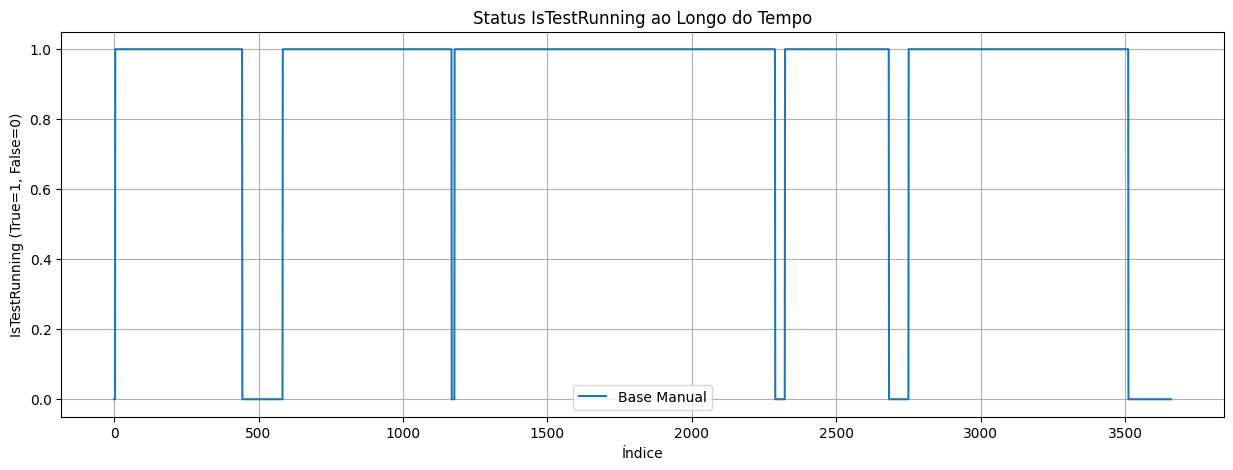

In [ ]:
# Carregar os arquivos CSV do Passmark (ajuste os caminhos caso necessário)
sem_base = pd.read_csv('data/Passmark/sem_base.csv')
base_manual = pd.read_csv('data/Passmark/base_manual.csv')
base_auto = pd.read_csv('data/Passmark/base_automatica.csv')

# Visualizar colunas para referência
print("Colunas disponíveis em sem_base:", sem_base.columns.tolist())
print("Colunas disponíveis em base_manual:", base_manual.columns.tolist())
print("Colunas disponíveis em base_auto:", base_auto.columns.tolist())

plt.figure(figsize=(15, 5))
#plt.plot(sem_base.index, sem_base['IsTestRunning'], label='Sem Base')
plt.plot(base_manual.index, base_manual['IsTestRunning'], label='Base Manual')
#plt.plot(base_auto.index, base_auto['IsTestRunning'], label='Base Automática')
plt.xlabel('Índice')
plt.ylabel('IsTestRunning (True=1, False=0)')
plt.title('Status IsTestRunning ao Longo do Tempo')
plt.legend()
plt.show()

In [ ]:
def segmentar_por_teste_refinado(df, nomes_testes):
    """
    Segmenta o DataFrame em sub-DataFrames com base em blocos contínuos de IsTestRunning=True.
    Assume que os testes ocorrem na ordem especificada e cada bloco contínuo True
    corresponde a um teste.
    """
    df_segmentado = {}
    test_running_series = df['IsTestRunning']

    # Encontrar os inícios dos blocos True
    # Um início é onde a série muda de False para True (ou True no primeiro elemento)
    starts = df.index[(test_running_series == True) & (test_running_series.shift(1).fillna(False) == False)]

    # Encontrar os fins dos blocos True
    # Um fim é onde a série muda de True para False (ou True no último elemento)
    ends = df.index[(test_running_series == True) & (test_running_series.shift(-1).fillna(False) == False)]

    # Garantir que o número de inícios e fins corresponda (pode haver um início sem fim ou um fim sem início no início/fim do df)
    # Precisamos ter o mesmo número de inícios e fins para cada bloco.
    # Se o primeiro elemento é True e o último é True, starts e ends devem ter o mesmo tamanho.
    # Se o primeiro é False e o último é False, starts e ends devem ter o mesmo tamanho.
    # Outros casos precisam ser tratados. Assumindo blocos completos de True.
    if len(starts) != len(ends):
        print(f"Aviso: Número de inícios ({len(starts)}) não corresponde ao número de fins ({len(ends)}). Verifique seus dados.")
        # Tentar ajustar, talvez descartando o último início se não houver fim correspondente
        min_len = min(len(starts), len(ends))
        starts = starts[:min_len]
        ends = ends[:min_len]


    # Garantir que o número de segmentos encontrados corresponda ao número de testes esperados
    if len(starts) != len(nomes_testes):
        print(f"Aviso: O número de períodos True detectados ({len(starts)}) não corresponde ao número de testes esperados ({len(nomes_testes)}). Verifique seus dados ou a ordem dos testes.")
        # Tentar segmentar com base no menor número
        num_segmentos = min(len(starts), len(nomes_testes))
        starts = starts[:num_segmentos]
        ends = ends[:num_segmentos]
    else:
        num_segmentos = len(nomes_testes)


    for i in range(num_segmentos):
        # O intervalo do teste é do início ao fim do bloco True
        df_segmentado[nomes_testes[i]] = df.loc[starts[i]:ends[i]]

    return df_segmentado

# Nomes dos testes na ordem em que ocorrem
nomes_testes = ['CPU Mark', '2D Mark', '3D Mark', 'Memory Mark', 'Disk Mark']

# Segmentar cada cenário
sem_base_segmentado = segmentar_por_teste_refinado(sem_base, nomes_testes)
base_manual_segmentado = segmentar_por_teste_refinado(base_manual, nomes_testes)
base_auto_segmentado = segmentar_por_teste_refinado(base_auto, nomes_testes)


<ipython-input-84-327123756>:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  starts = df.index[(test_running_series == True) & (test_running_series.shift(1).fillna(False) == False)]
<ipython-input-84-327123756>:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ends = df.index[(test_running_series == True) & (test_running_series.shift(-1).fillna(False) == False)]


In [ ]:
# Dicionários para armazenar os resultados por teste e cenário
summary_por_teste = {}
flags_por_teste = {}
power_por_teste = {}

for teste in nomes_testes:
    print(f"\n--- Resultados para: {teste} ---")

    # Calcular resumos para cada cenário e este teste específico
    summary_sem = resumir(sem_base_segmentado.get(teste, pd.DataFrame())) # Usar .get para evitar erro se o teste não existir
    summary_manual = resumir(base_manual_segmentado.get(teste, pd.DataFrame()))
    summary_auto = resumir(base_auto_segmentado.get(teste, pd.DataFrame()))

    # Montar DataFrame de resumo para este teste
    summary_df_teste = pd.DataFrame([
        summary_sem,
        summary_manual,
        summary_auto
    ], index=['Sem Base', 'Base Manual', 'Base Automática'])
    summary_df_teste = summary_df_teste.round(2)
    summary_por_teste[teste] = summary_df_teste # Armazenar para referência futura
    print("\nTabela de Resumo:")
    display(summary_df_teste)

    # Gerar tabelas de flags para cada cenário e este teste específico
    flags_sem = calcular_flags(sem_base_segmentado.get(teste, pd.DataFrame()), 'Sem Base')
    flags_manual = calcular_flags(base_manual_segmentado.get(teste, pd.DataFrame()), 'Base Manual')
    flags_auto = calcular_flags(base_auto_segmentado.get(teste, pd.DataFrame()), 'Base Automática')

    df_flags_teste = pd.DataFrame([flags_sem, flags_manual, flags_auto])
    flags_por_teste[teste] = df_flags_teste # Armazenar
    print("\nTabela de Flags (Throttling e Critical Temp):")
    display(df_flags_teste)

    # Calcular potência para cada cenário e este teste específico
    power_sem = resumir_potencia(sem_base_segmentado.get(teste, pd.DataFrame()), 'Sem Base')
    power_manual = resumir_potencia(base_manual_segmentado.get(teste, pd.DataFrame()), 'Base Manual')
    power_auto = resumir_potencia(base_auto_segmentado.get(teste, pd.DataFrame()), 'Base Automática')

    df_power_teste = pd.DataFrame([power_sem, power_manual, power_auto])
    power_por_teste[teste] = df_power_teste # Armazenar
    print("\nTabela de Potência (W):")
    display(df_power_teste)


--- Resultados para: CPU Mark ---

Tabela de Resumo:


,CPU_Temp_Mean,CPU_Temp_Max,CPU_Temp_Min,CPU_Temp_Std,GPU_Temp_Mean,GPU_Temp_Max,GPU_Temp_Min,GPU_Temp_Std,RPM_Mean,RPM_Max,RPM_Min,RPM_Std,Media_PC_Fan_Mean,Media_PC_Fan_Max,Media_PC_Fan_Min,Media_PC_Fan_Std,Diferenca_Fan_Abs_Mean,Diferenca_Fan_Abs_Max,Diferenca_Fan_Abs_Min,Diferenca_Fan_Abs_Std,Ruido_Fan_Mean,Ruido_Fan_Max,Ruido_Fan_Min,Ruido_Fan_Std,Disk_Temperature_Mean,Disk_Temperature_Max,Disk_Temperature_Min,Disk_Temperature_Std,GPU_Hotspot_temp_Mean,GPU_Hotspot_temp_Max,GPU_Hotspot_temp_Min,GPU_Hotspot_temp_Std,CPU_Core_Clocks_Mean,CPU_Core_Clocks_Max,CPU_Core_Clocks_Min,CPU_Core_Clocks_Std,CPU_Core_Usage_Mean,CPU_Core_Usage_Max,CPU_Core_Usage_Min,CPU_Core_Usage_Std,Gpu_Core_Clocks_Mean,Gpu_Core_Clocks_Max,Gpu_Core_Clocks_Min,Gpu_Core_Clocks_Std,Gpu_Core_Usage_Mean,Gpu_Core_Usage_Max,Gpu_Core_Usage_Min,Gpu_Core_Usage_Std,Gpu_Core_Clock_Mean,Gpu_Core_Clock_Max,Gpu_Core_Clock_Min,Gpu_Core_Clock_Std,Cpu_Package_Power_Mean,Cpu_Package_Power_Max,Cpu_Package_Power_Min,Cpu_Package_Power_Std
Sem Base,64.14,87,52,8.84,50.02,51.8,48.3,0.87,0.00,0,0,0.00,3928.38,4318.0,3823.0,112.64,223.41,451,0,64.49,49.48,52.03,48.68,0.77,30.22,31,30,0.41,58.88,60.7,56.9,0.92,3393.40,3993.2,2393.0,715.38,39.99,100.0,1.6,32.22,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,28.48,55.96,4.87,12.21
Base Manual,56.19,80,43,8.56,39.61,41.8,37.9,0.89,2266.84,2280,2250,14.90,3122.92,3412.5,2224.0,336.52,217.18,313,0,40.45,61.95,63.03,61.57,0.37,30.79,33,30,0.73,48.81,51.0,46.9,0.94,3403.23,3994.2,2392.4,705.18,43.52,100.0,2.0,33.98,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,28.83,55.92,4.75,12.08
Base Automática,64.31,87,47,9.15,44.14,46.4,42.0,0.96,1351.30,2130,870,243.23,3393.38,4318.0,3030.5,297.86,212.22,897,0,118.52,52.14,59.86,45.26,2.85,34.13,35,33,0.44,53.26,55.6,50.9,1.03,3628.53,3994.2,2393.0,590.63,47.39,100.0,3.1,33.28,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,30.98,55.73,4.86,12.75



Tabela de Flags (Throttling e Critical Temp):


,Core Thermal Throttling (avg) [Yes/No] #eventos,Core Thermal Throttling (avg) [Yes/No] %tempo,Core Critical Temperature (avg) [Yes/No] #eventos,Core Critical Temperature (avg) [Yes/No] %tempo,Package/Ring Thermal Throttling [Yes/No] #eventos,Package/Ring Thermal Throttling [Yes/No] %tempo,Package/Ring Critical Temperature [Yes/No] #eventos,Package/Ring Critical Temperature [Yes/No] %tempo
Sem Base,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Manual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Automática,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Tabela de Potência (W):


,CPU_Power_Mean (W),CPU_Power_Std (W),CPU_Power_Max (W),GPU_Power_Mean (W),GPU_Power_Std (W),GPU_Power_Max (W)
Sem Base,28.482100,12.206030,55.955,14.494823,0.220887,15.046
Base Manual,28.831580,12.082265,55.922,13.631459,0.070998,13.841
Base Automática,30.982895,12.754724,55.726,13.699023,0.081715,14.011



--- Resultados para: 2D Mark ---

Tabela de Resumo:


,CPU_Temp_Mean,CPU_Temp_Max,CPU_Temp_Min,CPU_Temp_Std,GPU_Temp_Mean,GPU_Temp_Max,GPU_Temp_Min,GPU_Temp_Std,RPM_Mean,RPM_Max,RPM_Min,RPM_Std,Media_PC_Fan_Mean,Media_PC_Fan_Max,Media_PC_Fan_Min,Media_PC_Fan_Std,Diferenca_Fan_Abs_Mean,Diferenca_Fan_Abs_Max,Diferenca_Fan_Abs_Min,Diferenca_Fan_Abs_Std,Ruido_Fan_Mean,Ruido_Fan_Max,Ruido_Fan_Min,Ruido_Fan_Std,Disk_Temperature_Mean,Disk_Temperature_Max,Disk_Temperature_Min,Disk_Temperature_Std,GPU_Hotspot_temp_Mean,GPU_Hotspot_temp_Max,GPU_Hotspot_temp_Min,GPU_Hotspot_temp_Std,CPU_Core_Clocks_Mean,CPU_Core_Clocks_Max,CPU_Core_Clocks_Min,CPU_Core_Clocks_Std,CPU_Core_Usage_Mean,CPU_Core_Usage_Max,CPU_Core_Usage_Min,CPU_Core_Usage_Std,Gpu_Core_Clocks_Mean,Gpu_Core_Clocks_Max,Gpu_Core_Clocks_Min,Gpu_Core_Clocks_Std,Gpu_Core_Usage_Mean,Gpu_Core_Usage_Max,Gpu_Core_Usage_Min,Gpu_Core_Usage_Std,Gpu_Core_Clock_Mean,Gpu_Core_Clock_Max,Gpu_Core_Clock_Min,Gpu_Core_Clock_Std,Cpu_Package_Power_Mean,Cpu_Package_Power_Max,Cpu_Package_Power_Min,Cpu_Package_Power_Std
Sem Base,61.86,72,45,5.41,47.36,50.0,42.1,1.33,0.00,0,0,0.00,3878.90,3898.5,3823.0,9.96,240.77,250,146,19.73,49.07,49.20,48.68,0.07,30.00,31,30,0.04,56.10,59.2,50.8,1.37,3807.91,3993.2,2392.4,436.84,20.08,44.2,4.7,7.36,1464.26,1935.0,1395.0,180.68,13.42,87.0,0.0,23.37,1464.26,1935.0,1395.0,180.68,26.56,36.14,5.50,4.03
Base Manual,55.47,66,42,5.18,38.49,40.9,37.4,0.62,2261.54,2280,2250,14.61,2680.88,2781.0,2290.0,176.53,156.36,235,0,65.18,62.04,62.90,61.71,0.35,29.10,30,29,0.29,47.53,50.4,46.2,0.69,3826.90,3994.2,2392.4,411.93,20.46,49.6,3.1,7.69,1464.49,1950.0,1395.0,181.36,13.42,87.0,0.0,23.62,1464.49,1950.0,1395.0,181.36,26.60,39.04,5.42,4.45
Base Automática,61.51,73,46,5.66,43.03,45.3,41.5,0.66,1317.79,1950,780,147.46,3086.66,3112.5,3024.0,10.73,181.70,334,157,20.18,49.67,57.08,44.95,1.46,33.01,34,33,0.08,52.12,54.9,50.3,0.76,3821.07,3994.2,2392.4,424.33,20.20,49.9,3.4,7.57,1467.92,1935.0,1395.0,184.71,13.49,88.0,0.0,23.78,1467.92,1935.0,1395.0,184.71,26.64,41.42,5.41,4.50



Tabela de Flags (Throttling e Critical Temp):


,Core Thermal Throttling (avg) [Yes/No] #eventos,Core Thermal Throttling (avg) [Yes/No] %tempo,Core Critical Temperature (avg) [Yes/No] #eventos,Core Critical Temperature (avg) [Yes/No] %tempo,Package/Ring Thermal Throttling [Yes/No] #eventos,Package/Ring Thermal Throttling [Yes/No] %tempo,Package/Ring Critical Temperature [Yes/No] #eventos,Package/Ring Critical Temperature [Yes/No] %tempo
Sem Base,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Manual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Automática,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Tabela de Potência (W):


,CPU_Power_Mean (W),CPU_Power_Std (W),CPU_Power_Max (W),GPU_Power_Mean (W),GPU_Power_Std (W),GPU_Power_Max (W)
Sem Base,26.555005,4.027396,36.143,15.149554,2.568398,26.321
Base Manual,26.598556,4.446835,39.039,14.541685,2.238696,24.296
Base Automática,26.642909,4.500129,41.421,14.642303,2.471742,25.406



--- Resultados para: 3D Mark ---

Tabela de Resumo:


,CPU_Temp_Mean,CPU_Temp_Max,CPU_Temp_Min,CPU_Temp_Std,GPU_Temp_Mean,GPU_Temp_Max,GPU_Temp_Min,GPU_Temp_Std,RPM_Mean,RPM_Max,RPM_Min,RPM_Std,Media_PC_Fan_Mean,Media_PC_Fan_Max,Media_PC_Fan_Min,Media_PC_Fan_Std,Diferenca_Fan_Abs_Mean,Diferenca_Fan_Abs_Max,Diferenca_Fan_Abs_Min,Diferenca_Fan_Abs_Std,Ruido_Fan_Mean,Ruido_Fan_Max,Ruido_Fan_Min,Ruido_Fan_Std,Disk_Temperature_Mean,Disk_Temperature_Max,Disk_Temperature_Min,Disk_Temperature_Std,GPU_Hotspot_temp_Mean,GPU_Hotspot_temp_Max,GPU_Hotspot_temp_Min,GPU_Hotspot_temp_Std,CPU_Core_Clocks_Mean,CPU_Core_Clocks_Max,CPU_Core_Clocks_Min,CPU_Core_Clocks_Std,CPU_Core_Usage_Mean,CPU_Core_Usage_Max,CPU_Core_Usage_Min,CPU_Core_Usage_Std,Gpu_Core_Clocks_Mean,Gpu_Core_Clocks_Max,Gpu_Core_Clocks_Min,Gpu_Core_Clocks_Std,Gpu_Core_Usage_Mean,Gpu_Core_Usage_Max,Gpu_Core_Usage_Min,Gpu_Core_Usage_Std,Gpu_Core_Clock_Mean,Gpu_Core_Clock_Max,Gpu_Core_Clock_Min,Gpu_Core_Clock_Std,Cpu_Package_Power_Mean,Cpu_Package_Power_Max,Cpu_Package_Power_Min,Cpu_Package_Power_Std
Sem Base,69.90,86,56,7.14,60.79,64.3,49.3,2.29,0.03,30,0,0.90,3979.37,4288.5,3823.0,172.89,186.08,614,0,91.97,49.92,51.84,48.68,1.17,32.05,33,30,1.01,70.49,74.4,58.1,2.50,3424.71,3994.2,2391.8,707.67,17.35,48.4,1.5,7.07,1801.66,1920.0,1395.0,123.16,81.56,100.0,0.0,30.20,1801.66,1920.0,1395.0,123.16,20.09,37.17,4.85,7.90
Base Manual,60.34,87,40,8.13,48.41,53.3,36.5,2.25,2263.65,2280,2250,14.95,3026.63,4288.5,2742.0,266.49,205.39,582,0,49.51,61.87,62.60,61.57,0.25,30.26,32,29,0.78,57.97,63.2,45.5,2.30,3509.99,3994.2,2391.2,680.76,19.31,68.6,1.7,8.97,1839.72,1935.0,1395.0,135.14,81.49,100.0,0.0,30.04,1839.72,1935.0,1395.0,135.14,21.56,51.88,5.07,8.57
Base Automática,62.75,81,50,6.81,51.61,54.4,41.2,1.81,1613.03,2250,750,123.10,3287.50,3356.5,3063.5,103.40,222.18,379,157,24.15,53.50,61.58,44.77,1.50,33.83,34,33,0.38,61.37,64.3,50.1,1.95,3425.99,3994.2,2391.8,709.47,17.57,47.1,1.1,7.33,1831.04,1920.0,1395.0,132.87,81.67,100.0,0.0,30.08,1831.04,1920.0,1395.0,132.87,20.25,37.89,5.16,7.70



Tabela de Flags (Throttling e Critical Temp):


,Core Thermal Throttling (avg) [Yes/No] #eventos,Core Thermal Throttling (avg) [Yes/No] %tempo,Core Critical Temperature (avg) [Yes/No] #eventos,Core Critical Temperature (avg) [Yes/No] %tempo,Package/Ring Thermal Throttling [Yes/No] #eventos,Package/Ring Thermal Throttling [Yes/No] %tempo,Package/Ring Critical Temperature [Yes/No] #eventos,Package/Ring Critical Temperature [Yes/No] %tempo
Sem Base,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Manual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Automática,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Tabela de Potência (W):


,CPU_Power_Mean (W),CPU_Power_Std (W),CPU_Power_Max (W),GPU_Power_Mean (W),GPU_Power_Std (W),GPU_Power_Max (W)
Sem Base,20.087241,7.904281,37.166,44.117389,10.591779,51.854
Base Manual,21.560907,8.569968,51.875,43.769788,11.059595,51.416
Base Automática,20.246165,7.699537,37.893,43.924100,10.967093,51.626



--- Resultados para: Memory Mark ---

Tabela de Resumo:


,CPU_Temp_Mean,CPU_Temp_Max,CPU_Temp_Min,CPU_Temp_Std,GPU_Temp_Mean,GPU_Temp_Max,GPU_Temp_Min,GPU_Temp_Std,RPM_Mean,RPM_Max,RPM_Min,RPM_Std,Media_PC_Fan_Mean,Media_PC_Fan_Max,Media_PC_Fan_Min,Media_PC_Fan_Std,Diferenca_Fan_Abs_Mean,Diferenca_Fan_Abs_Max,Diferenca_Fan_Abs_Min,Diferenca_Fan_Abs_Std,Ruido_Fan_Mean,Ruido_Fan_Max,Ruido_Fan_Min,Ruido_Fan_Std,Disk_Temperature_Mean,Disk_Temperature_Max,Disk_Temperature_Min,Disk_Temperature_Std,GPU_Hotspot_temp_Mean,GPU_Hotspot_temp_Max,GPU_Hotspot_temp_Min,GPU_Hotspot_temp_Std,CPU_Core_Clocks_Mean,CPU_Core_Clocks_Max,CPU_Core_Clocks_Min,CPU_Core_Clocks_Std,CPU_Core_Usage_Mean,CPU_Core_Usage_Max,CPU_Core_Usage_Min,CPU_Core_Usage_Std,Gpu_Core_Clocks_Mean,Gpu_Core_Clocks_Max,Gpu_Core_Clocks_Min,Gpu_Core_Clocks_Std,Gpu_Core_Usage_Mean,Gpu_Core_Usage_Max,Gpu_Core_Usage_Min,Gpu_Core_Usage_Std,Gpu_Core_Clock_Mean,Gpu_Core_Clock_Max,Gpu_Core_Clock_Min,Gpu_Core_Clock_Std,Cpu_Package_Power_Mean,Cpu_Package_Power_Max,Cpu_Package_Power_Min,Cpu_Package_Power_Std
Sem Base,66.19,91,52,8.30,51.64,56.0,48.2,1.81,0.00,0,0,0.00,3846.22,3898.5,3799.5,25.68,165.07,297,50,65.76,48.84,49.20,48.51,0.18,32.51,33,31,0.58,60.47,65.1,56.9,1.87,3664.48,3993.2,2392.4,539.24,26.05,99.3,1.2,17.54,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,25.10,49.76,4.41,12.47
Base Manual,55.98,74,42,8.74,38.24,40.1,36.4,0.94,2264.17,2280,2250,15.00,2771.40,2793.0,2755.5,9.28,179.60,206,155,15.23,61.97,62.25,61.70,0.26,30.19,32,29,0.60,47.38,49.5,45.4,1.02,3714.36,3994.2,2393.0,505.45,26.89,99.7,1.5,17.29,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,26.21,50.02,4.87,11.92
Base Automática,60.83,84,46,9.67,42.45,45.2,40.6,0.96,1364.50,2100,660,348.41,3168.02,3381.0,3024.0,120.83,195.55,380,99,29.69,52.00,59.42,44.41,3.47,33.47,34,33,0.50,51.67,54.9,49.6,1.10,3718.41,3993.2,2391.8,497.79,26.61,98.7,1.4,17.87,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,25.71,50.68,4.46,12.32



Tabela de Flags (Throttling e Critical Temp):


,Core Thermal Throttling (avg) [Yes/No] #eventos,Core Thermal Throttling (avg) [Yes/No] %tempo,Core Critical Temperature (avg) [Yes/No] #eventos,Core Critical Temperature (avg) [Yes/No] %tempo,Package/Ring Thermal Throttling [Yes/No] #eventos,Package/Ring Thermal Throttling [Yes/No] %tempo,Package/Ring Critical Temperature [Yes/No] #eventos,Package/Ring Critical Temperature [Yes/No] %tempo
Sem Base,1.0,0.28,0.0,0.0,1.0,0.28,0.0,0.0
Base Manual,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0
Base Automática,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0



Tabela de Potência (W):


,CPU_Power_Mean (W),CPU_Power_Std (W),CPU_Power_Max (W),GPU_Power_Mean (W),GPU_Power_Std (W),GPU_Power_Max (W)
Sem Base,25.095125,12.474811,49.755,14.424128,0.320180,15.255
Base Manual,26.205017,11.919212,50.021,13.683567,0.072863,13.948
Base Automática,25.714019,12.315125,50.685,13.716208,0.083222,14.094



--- Resultados para: Disk Mark ---

Tabela de Resumo:


,CPU_Temp_Mean,CPU_Temp_Max,CPU_Temp_Min,CPU_Temp_Std,GPU_Temp_Mean,GPU_Temp_Max,GPU_Temp_Min,GPU_Temp_Std,RPM_Mean,RPM_Max,RPM_Min,RPM_Std,Media_PC_Fan_Mean,Media_PC_Fan_Max,Media_PC_Fan_Min,Media_PC_Fan_Std,Diferenca_Fan_Abs_Mean,Diferenca_Fan_Abs_Max,Diferenca_Fan_Abs_Min,Diferenca_Fan_Abs_Std,Ruido_Fan_Mean,Ruido_Fan_Max,Ruido_Fan_Min,Ruido_Fan_Std,Disk_Temperature_Mean,Disk_Temperature_Max,Disk_Temperature_Min,Disk_Temperature_Std,GPU_Hotspot_temp_Mean,GPU_Hotspot_temp_Max,GPU_Hotspot_temp_Min,GPU_Hotspot_temp_Std,CPU_Core_Clocks_Mean,CPU_Core_Clocks_Max,CPU_Core_Clocks_Min,CPU_Core_Clocks_Std,CPU_Core_Usage_Mean,CPU_Core_Usage_Max,CPU_Core_Usage_Min,CPU_Core_Usage_Std,Gpu_Core_Clocks_Mean,Gpu_Core_Clocks_Max,Gpu_Core_Clocks_Min,Gpu_Core_Clocks_Std,Gpu_Core_Usage_Mean,Gpu_Core_Usage_Max,Gpu_Core_Usage_Min,Gpu_Core_Usage_Std,Gpu_Core_Clock_Mean,Gpu_Core_Clock_Max,Gpu_Core_Clock_Min,Gpu_Core_Clock_Std,Cpu_Package_Power_Mean,Cpu_Package_Power_Max,Cpu_Package_Power_Min,Cpu_Package_Power_Std
Sem Base,50.05,65,43,4.12,42.50,47.5,40.1,1.59,0.00,0,0,0.00,4845.37,4919.0,3798.0,197.86,226.86,918,49,60.91,55.35,55.67,48.50,1.26,30.47,32,30,0.53,51.27,56.3,48.8,1.60,3729.88,3994.2,2392.4,532.48,10.26,35.7,2.6,4.13,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,18.53,32.22,5.22,4.39
Base Manual,44.25,56,37,3.52,36.23,37.3,34.2,0.53,2261.27,2280,2250,14.54,2087.07,2099.0,2070.0,4.16,120.10,131,100,7.99,62.96,63.38,62.69,0.31,33.62,35,29,1.82,45.17,46.4,43.0,0.56,3692.74,3994.2,2392.4,588.05,10.77,37.5,2.0,4.65,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,18.21,35.79,5.78,4.63
Base Automática,48.48,61,41,3.97,38.76,42.3,36.9,1.25,822.18,1500,480,145.68,4541.58,4922.5,2715.5,732.44,173.82,451,0,62.23,53.95,57.59,43.23,3.46,34.45,35,32,0.73,47.77,51.3,45.8,1.27,3687.13,3994.2,2392.4,593.41,10.43,30.6,2.2,4.30,1395.0,1395.0,1395.0,0.0,0.0,0.0,0.0,0.0,1395.0,1395.0,1395.0,0.0,18.14,29.65,5.44,4.44



Tabela de Flags (Throttling e Critical Temp):


,Core Thermal Throttling (avg) [Yes/No] #eventos,Core Thermal Throttling (avg) [Yes/No] %tempo,Core Critical Temperature (avg) [Yes/No] #eventos,Core Critical Temperature (avg) [Yes/No] %tempo,Package/Ring Thermal Throttling [Yes/No] #eventos,Package/Ring Thermal Throttling [Yes/No] %tempo,Package/Ring Critical Temperature [Yes/No] #eventos,Package/Ring Critical Temperature [Yes/No] %tempo
Sem Base,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Manual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Base Automática,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Tabela de Potência (W):


,CPU_Power_Mean (W),CPU_Power_Std (W),CPU_Power_Max (W),GPU_Power_Mean (W),GPU_Power_Std (W),GPU_Power_Max (W)
Sem Base,18.531670,4.388930,32.225,13.756817,0.132716,14.415
Base Manual,18.205498,4.633632,35.788,13.633177,0.099241,14.008
Base Automática,18.139675,4.438673,29.650,13.634125,0.122057,14.058


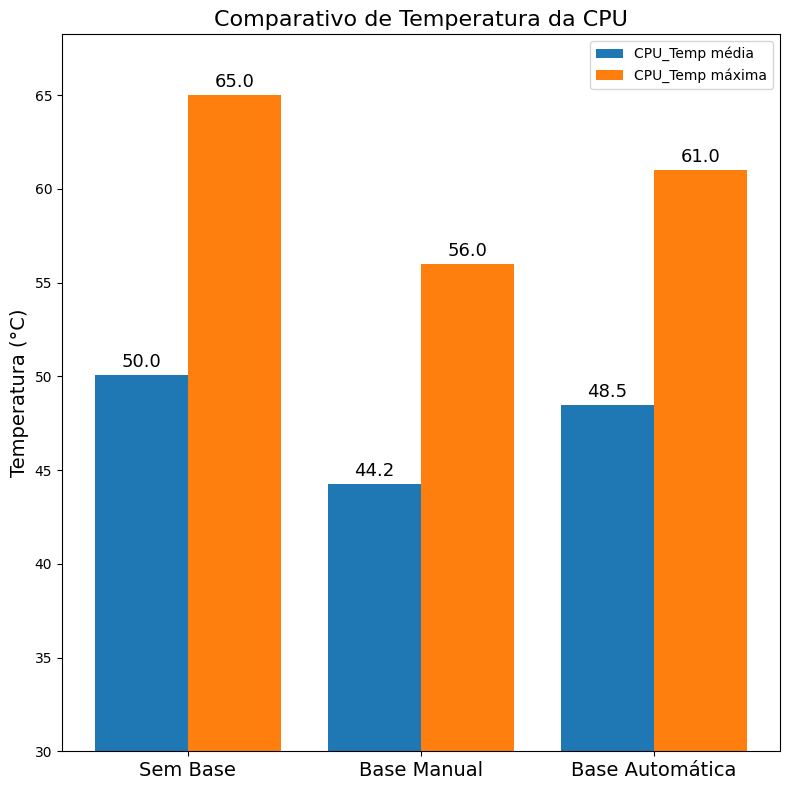

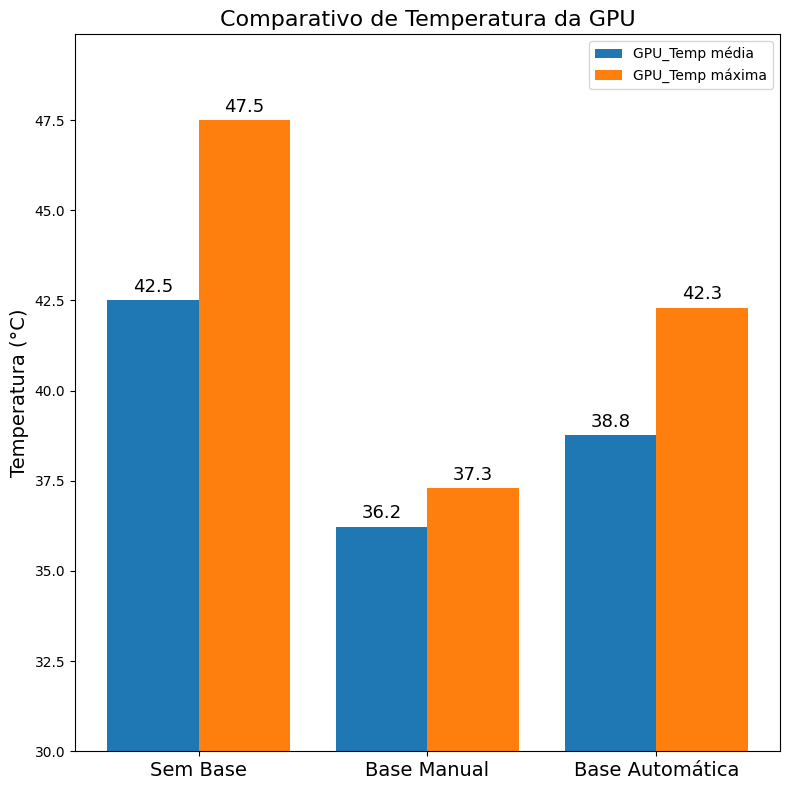

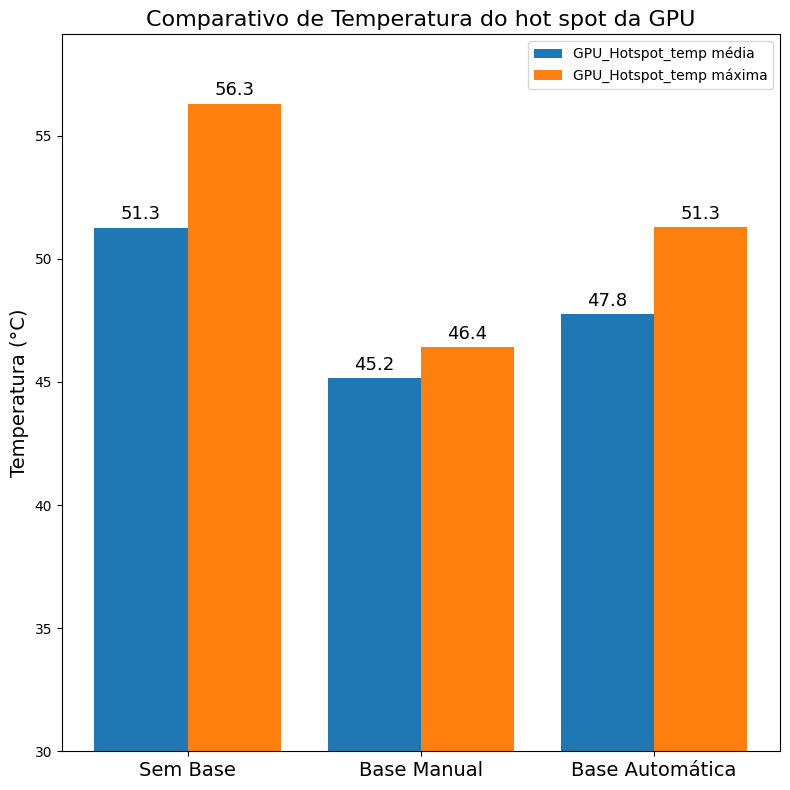

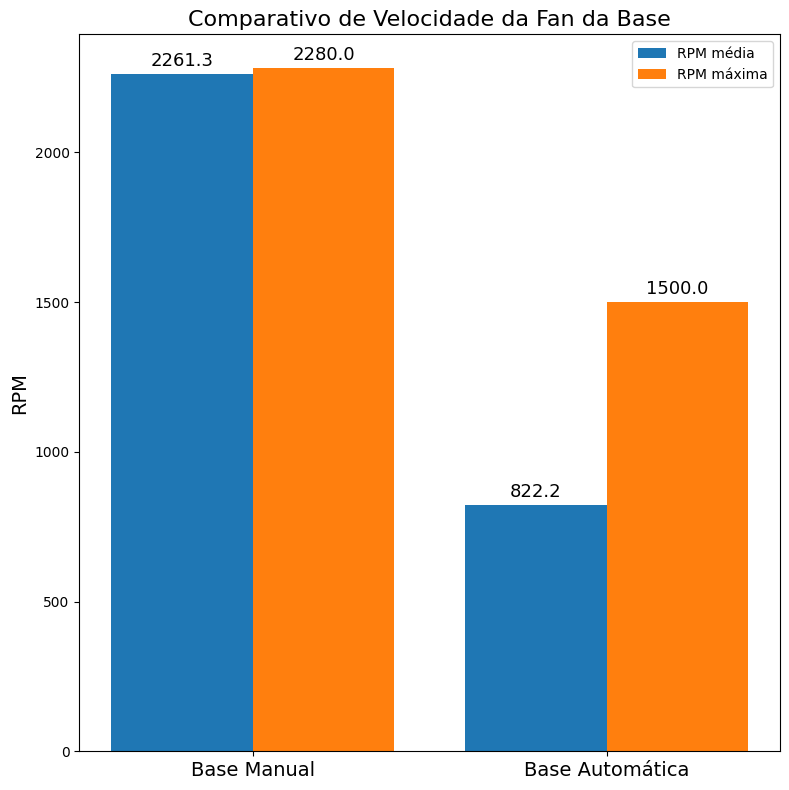

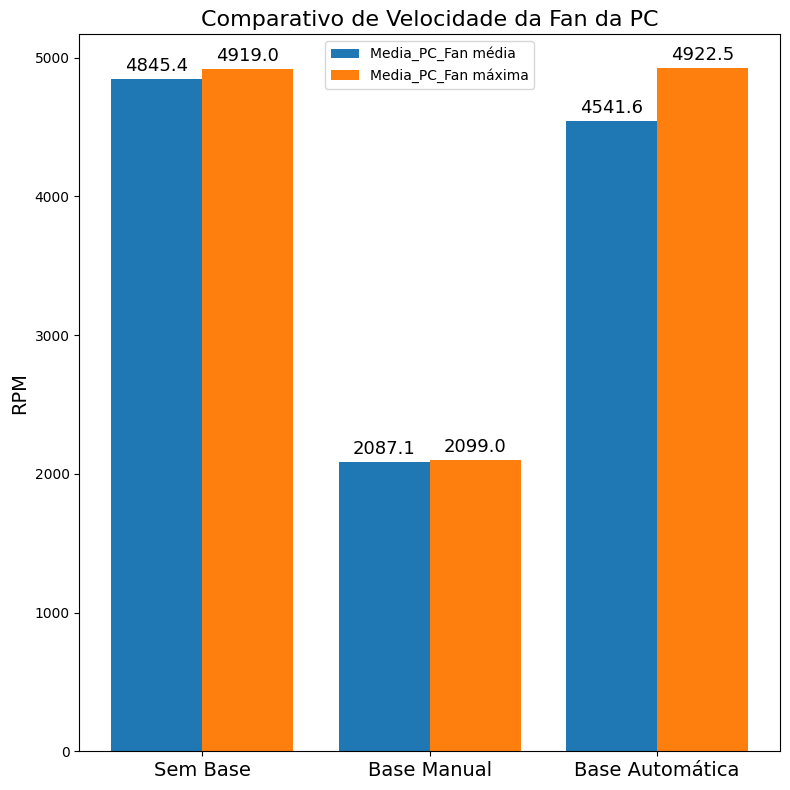

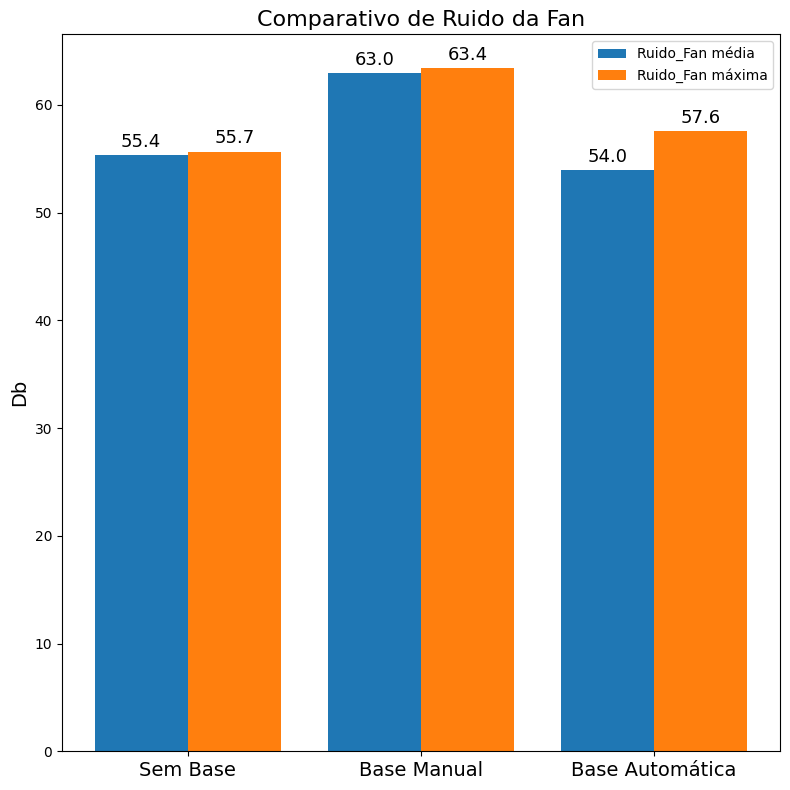

In [ ]:
plot_max_mean(summary_df_teste, 'CPU_Temp', 'Comparativo de Temperatura da CPU', 'Temperatura (°C)', ymin=30)
plot_max_mean(summary_df_teste, 'GPU_Temp', 'Comparativo de Temperatura da GPU', 'Temperatura (°C)', ymin=30)
plot_max_mean(summary_df_teste, 'GPU_Hotspot_temp', 'Comparativo de Temperatura do hot spot da GPU', 'Temperatura (°C)', ymin=30)
plot_max_mean(summary_df_teste, 'RPM', 'Comparativo de Velocidade da Fan da Base', 'RPM', ymin=0)
plot_max_mean(summary_df_teste, 'Media_PC_Fan', 'Comparativo de Velocidade da Fan da PC', 'RPM', ymin=0)
plot_max_mean(summary_df_teste, 'Ruido_Fan', 'Comparativo de Ruido da Fan', 'Db', ymin=0)


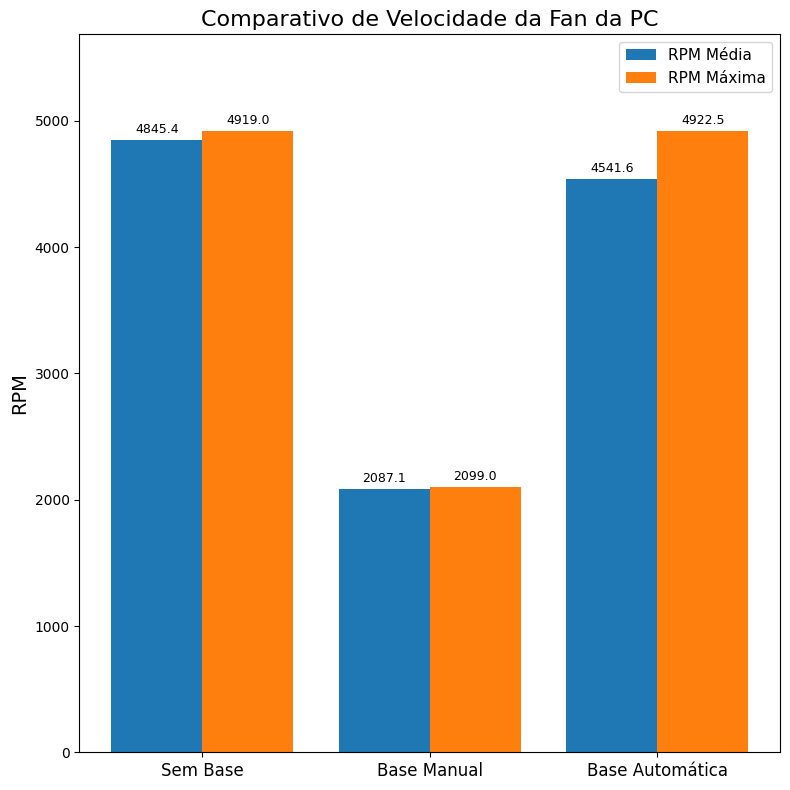

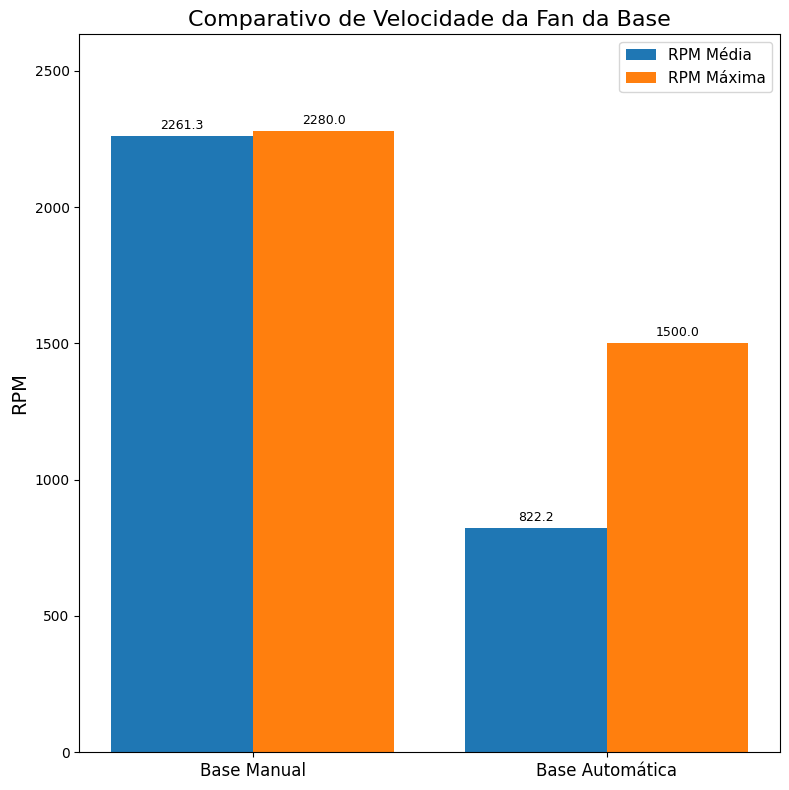

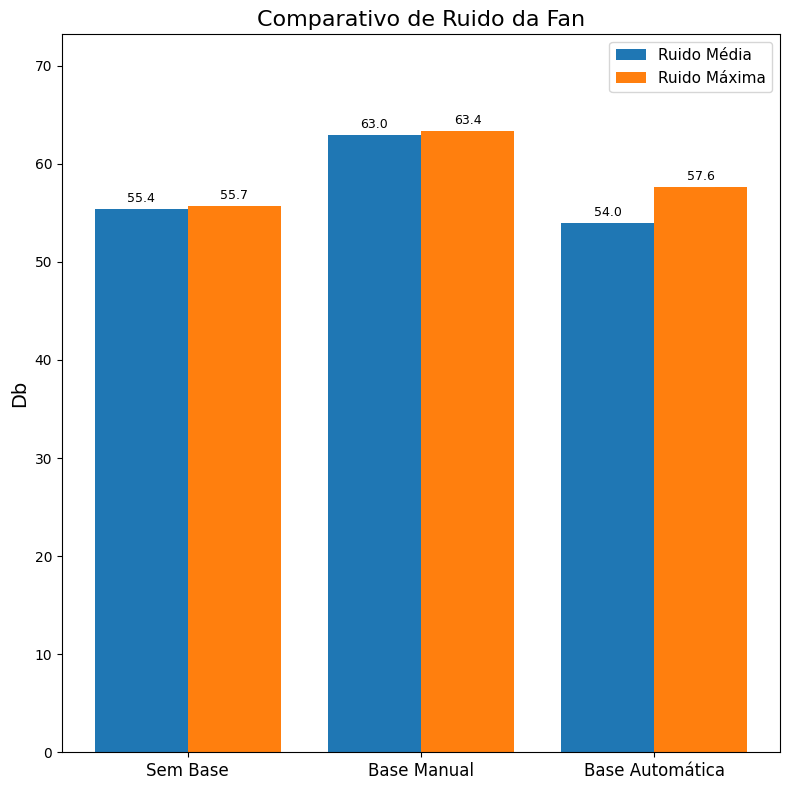

In [ ]:
plot_metrics_flexible(
    df_summary=summary_df_teste,
    metric_prefixes='Media_PC_Fan',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Velocidade da Fan da PC',
    ylabel='RPM',
    metric_prefixes_renamed=['RPM'],
    stats_renamed={'Mean': 'Média', 'Max': 'Máxima'}
)

plot_metrics_flexible(
    df_summary=summary_df_teste,
    metric_prefixes='RPM',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Velocidade da Fan da Base',
    ylabel='RPM',
    metric_prefixes_renamed=['RPM'],
    stats_renamed={'Mean': 'Média', 'Max': 'Máxima'}
)

plot_metrics_flexible(
    df_summary=summary_df_teste,
    metric_prefixes='Ruido_Fan',
    stats_to_plot=['Mean', 'Max'], # Duas estatísticas
    title='Comparativo de Ruido da Fan',
    ylabel='Db',
    metric_prefixes_renamed=['Ruido'],
    stats_renamed={'Mean': 'Média', 'Max': 'Máxima'}
)


--- Gráficos para: CPU Mark ---


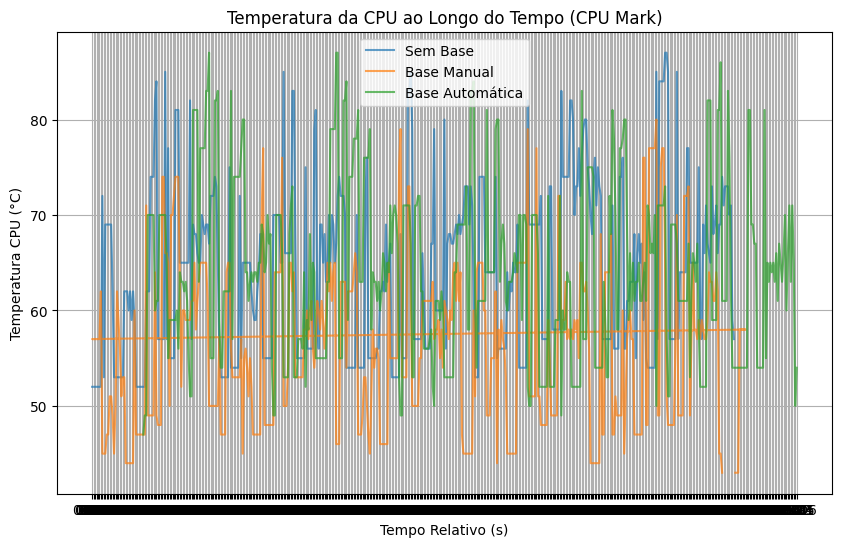

<ipython-input-88-4078147390>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_cpu_temp, labels=['Sem Base', 'Base Manual', 'Base Automática'])


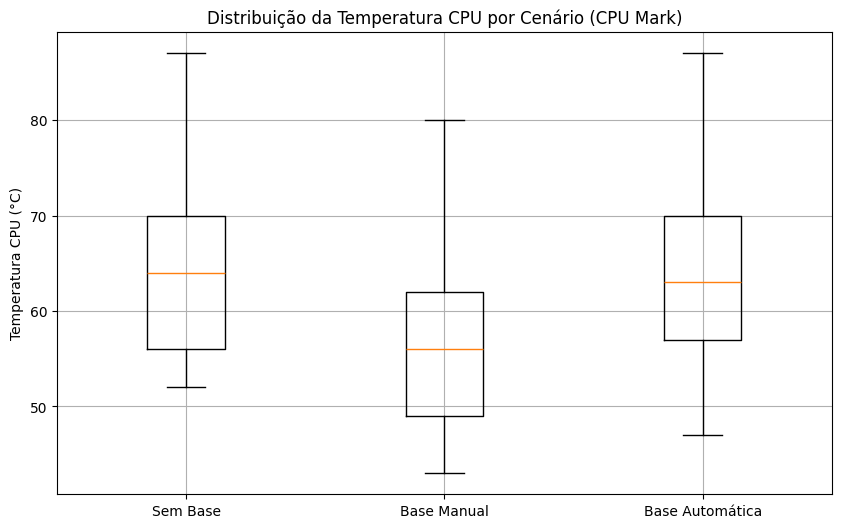


--- Gráficos para: 2D Mark ---


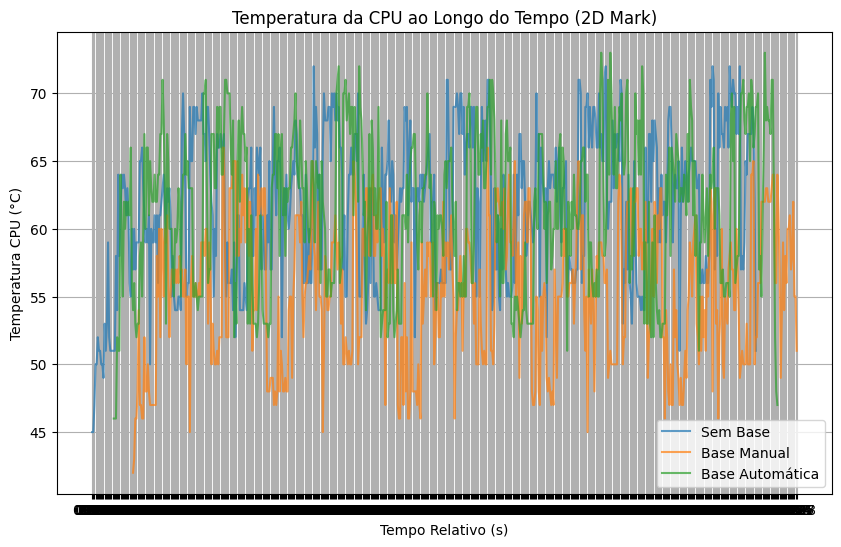

<ipython-input-88-4078147390>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_cpu_temp, labels=['Sem Base', 'Base Manual', 'Base Automática'])


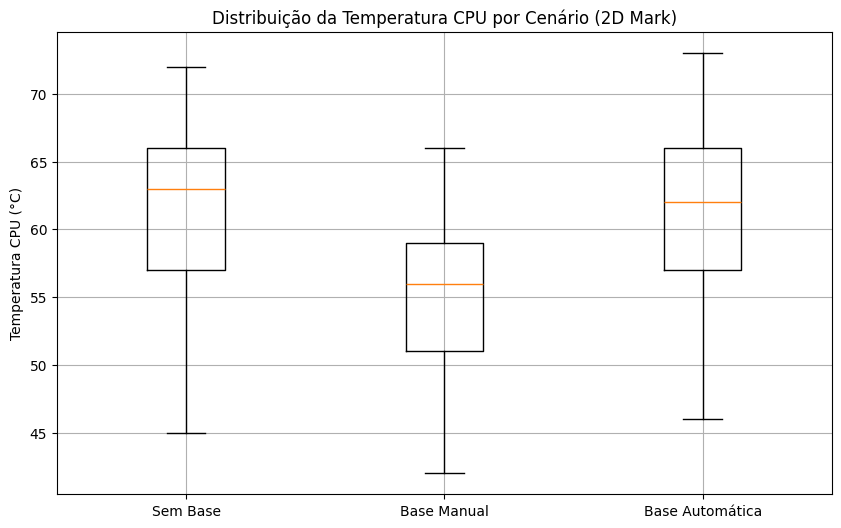


--- Gráficos para: 3D Mark ---


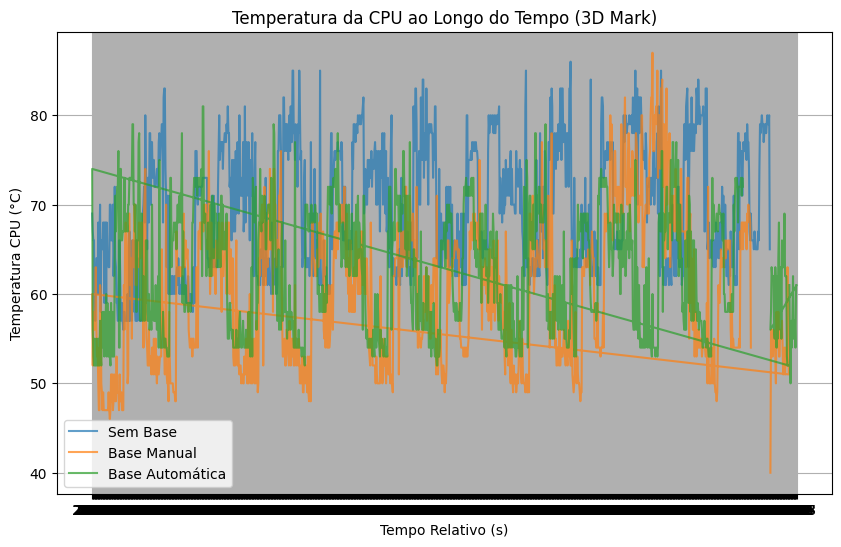

<ipython-input-88-4078147390>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_cpu_temp, labels=['Sem Base', 'Base Manual', 'Base Automática'])


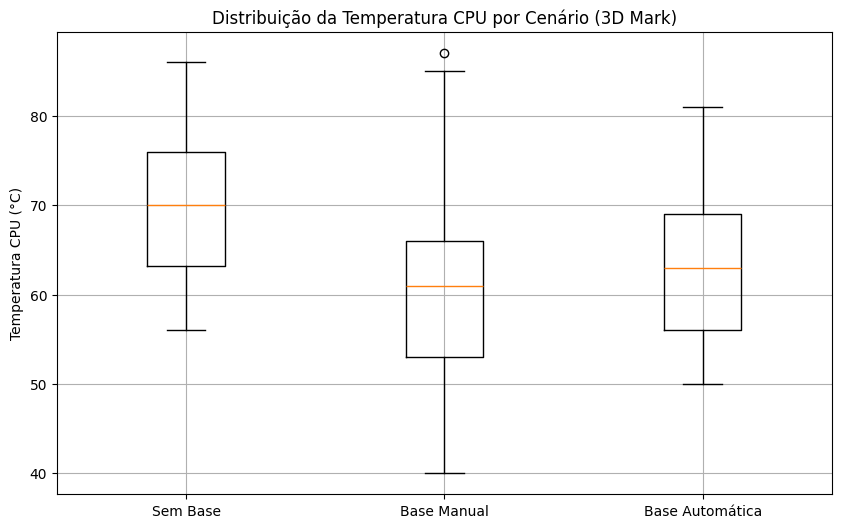


--- Gráficos para: Memory Mark ---


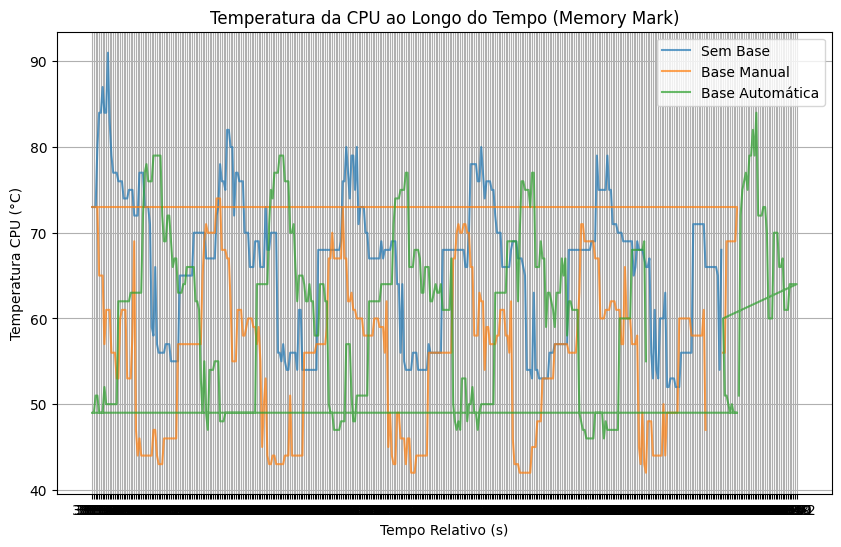

<ipython-input-88-4078147390>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_cpu_temp, labels=['Sem Base', 'Base Manual', 'Base Automática'])


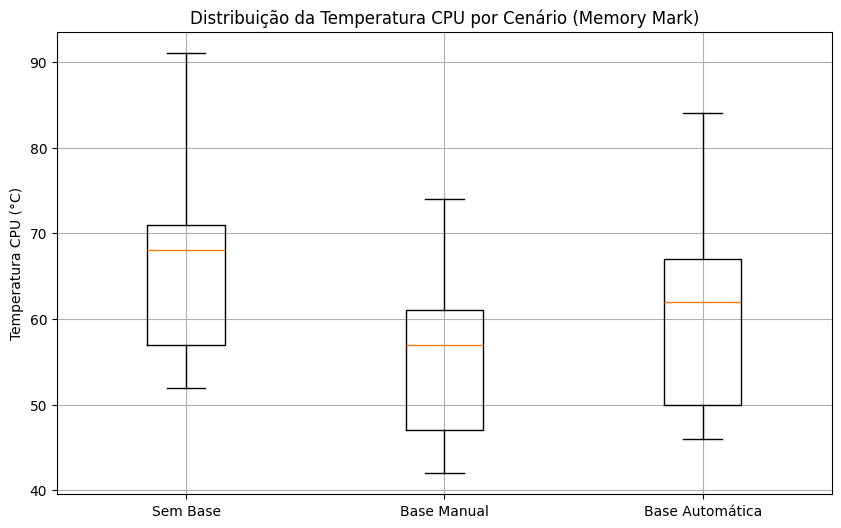


--- Gráficos para: Disk Mark ---


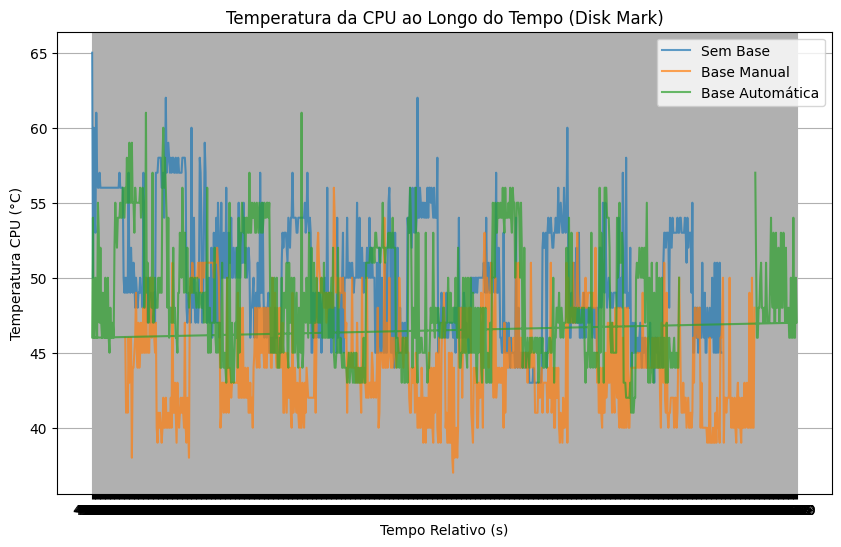

<ipython-input-88-4078147390>:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_cpu_temp, labels=['Sem Base', 'Base Manual', 'Base Automática'])


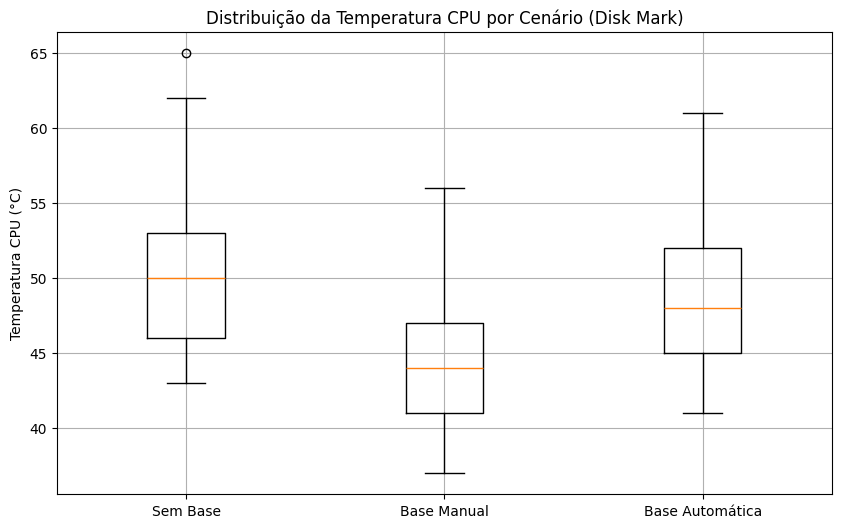

In [ ]:
# Exemplos de gráficos comparativos por teste

for teste in nomes_testes:
    print(f"\n--- Gráficos para: {teste} ---")

    # Verificar se os dados para este teste existem em todos os cenários
    if teste in sem_base_segmentado and teste in base_manual_segmentado and teste in base_auto_segmentado:

        # 1. Série temporal de temperatura da CPU para este teste
        plt.figure()
        plt.plot(sem_base_segmentado[teste]['relativeTime'], sem_base_segmentado[teste][cols['CPU_Temp']], label='Sem Base', alpha=0.7)
        plt.plot(base_manual_segmentado[teste]['relativeTime'], base_manual_segmentado[teste][cols['CPU_Temp']], label='Base Manual', alpha=0.7)
        plt.plot(base_auto_segmentado[teste]['relativeTime'], base_auto_segmentado[teste][cols['CPU_Temp']], label='Base Automática', alpha=0.7)
        plt.xlabel('Tempo Relativo (s)')
        plt.ylabel('Temperatura CPU (°C)')
        plt.title(f'Temperatura da CPU ao Longo do Tempo ({teste})')
        plt.legend()
        plt.show()

        # 2. Boxplot de Temperatura da CPU nos três cenários para este teste
        plt.figure()
        data_cpu_temp = [sem_base_segmentado[teste][cols['CPU_Temp']], base_manual_segmentado[teste][cols['CPU_Temp']], base_auto_segmentado[teste][cols['CPU_Temp']]]
        plt.boxplot(data_cpu_temp, labels=['Sem Base', 'Base Manual', 'Base Automática'])
        plt.ylabel('Temperatura CPU (°C)')
        plt.title(f'Distribuição da Temperatura CPU por Cenário ({teste})')
        plt.show()

        # # 3. Boxplot de FPS médio nos três cenários para este teste
        # if cols['FPS_Avg'] in sem_base_segmentado[teste].columns: # Verificar se a coluna FPS_Avg existe para este teste
        #      plt.figure()
        #      data_fps = [sem_base_segmentado[teste][cols['FPS_Avg']], base_manual_segmentado[teste][cols['FPS_Avg']], base_auto_segmentado[teste][cols['FPS_Avg']]]
        #      plt.boxplot(data_fps, labels=['Sem Base', 'Base Manual', 'Base Automática'])
        #      plt.ylabel('FPS Médio')
        #      plt.title(f'Distribuição de FPS Médio por Cenário ({teste})')
        #      plt.show()
        # else:
        #     print(f"Coluna {cols['FPS_Avg']} não encontrada para o teste {teste}. Pulando o gráfico de FPS.")

    else:
        print(f"Dados insuficientes para o teste {teste} em um ou mais cenários. Pulando gráficos.")

Agora, você pode usar esta função `mean_db` dentro da sua função `resumir` para calcular a média do ruído de forma correta. Você pode substituir a linha que calcula a média do Ruido_Fan pela chamada a esta nova função.


--- Gráficos para: CPU Mark ---


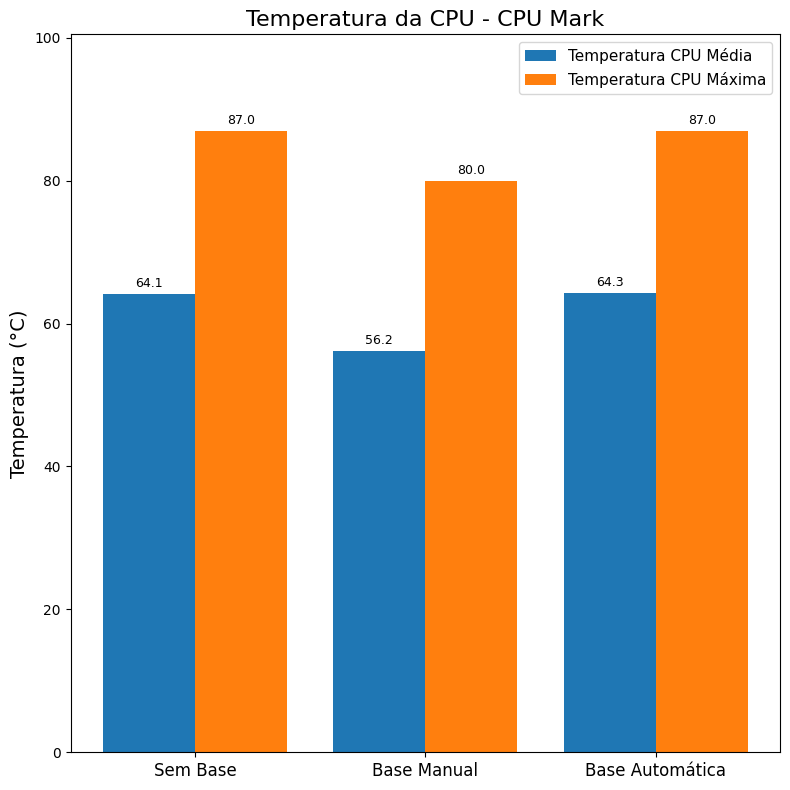


--- Gráficos para: 2D Mark ---


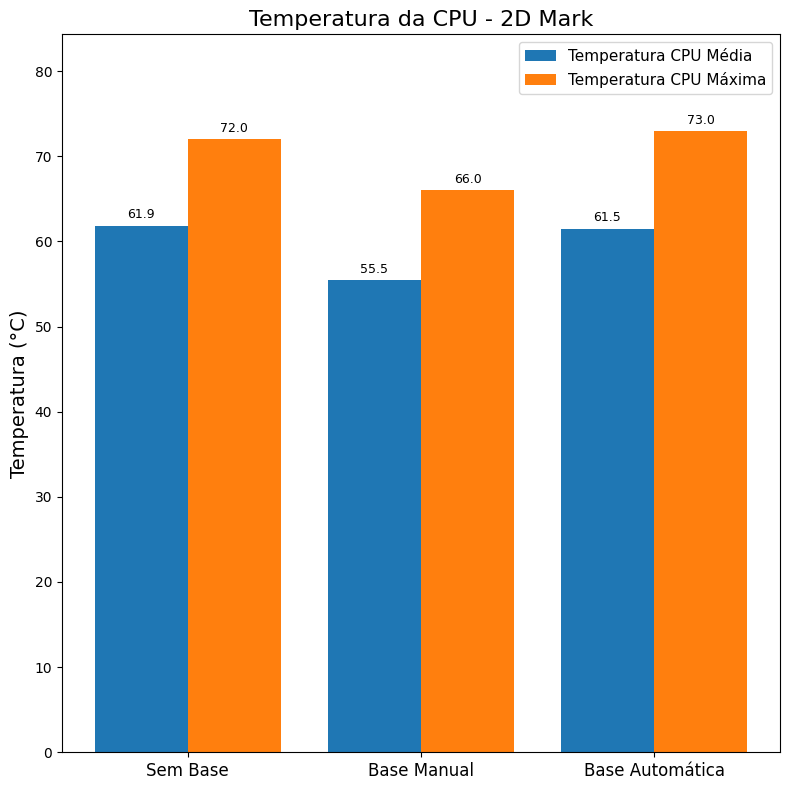


--- Gráficos para: Disk Mark ---


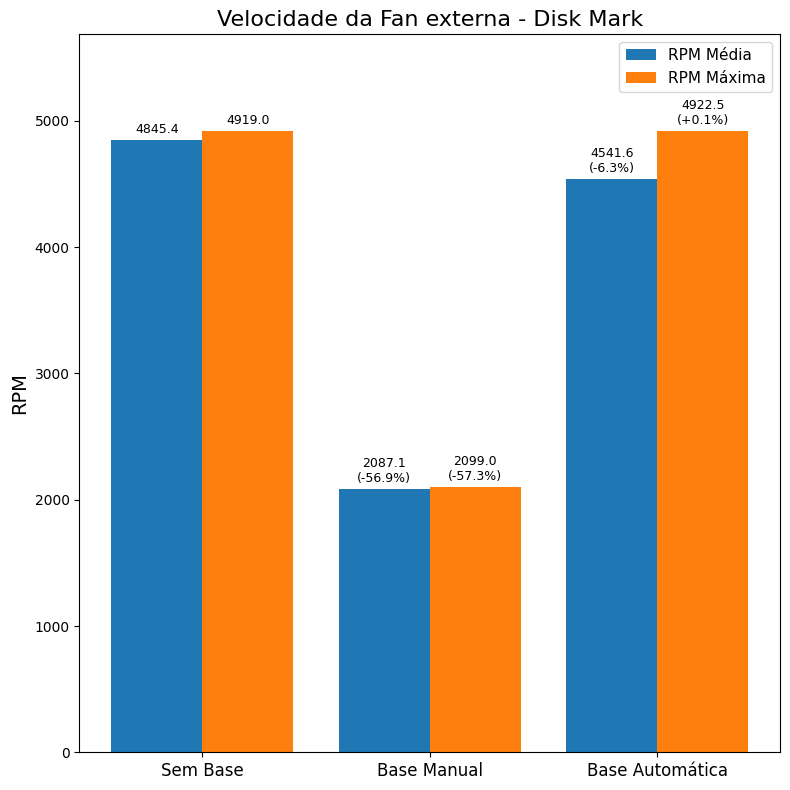

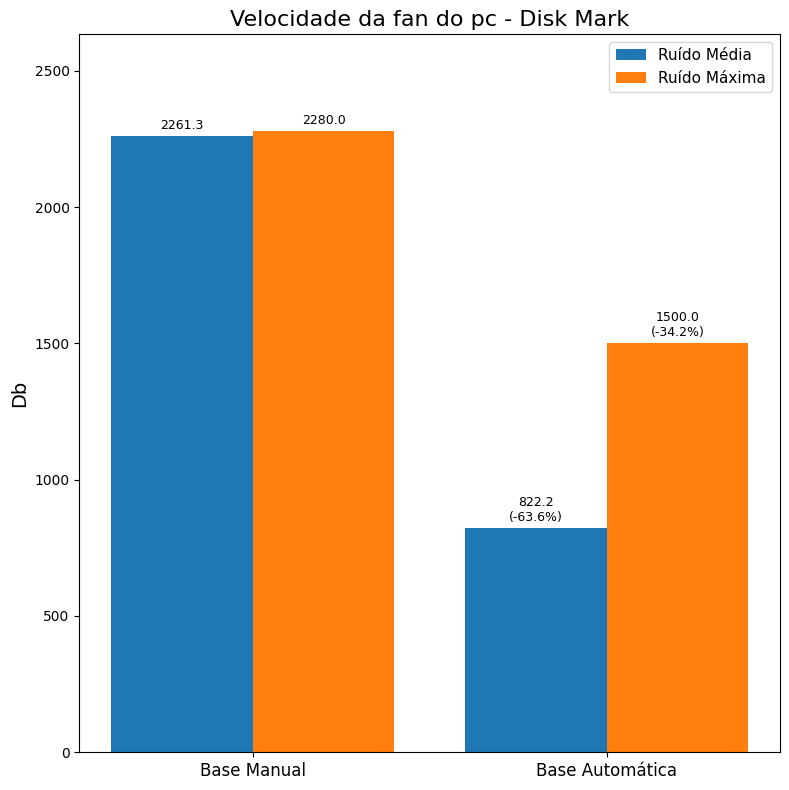

In [ ]:
# Gráficos de histograma para CPU_Temp (Mean e Max) no teste 'CPU Mark'
print(f"\n--- Gráficos para: CPU Mark ---")
if 'CPU Mark' in summary_por_teste:
    plot_metrics_flexible(
        df_summary=summary_por_teste['CPU Mark'],
        metric_prefixes='CPU_Temp',
        stats_to_plot=['Mean', 'Max'],
        title='Temperatura da CPU - CPU Mark',
        ylabel='Temperatura (°C)',
        metric_prefixes_renamed=['Temperatura CPU'],
        stats_renamed={'Mean': 'Média', 'Max': 'Máxima'},
        y_min=0
    )
else:
    print("Dados para 'CPU Mark' não encontrados no summary_por_teste.")

# Gráficos de histograma para CPU_Temp (Mean e Max) no teste '2D Mark'
print(f"\n--- Gráficos para: 2D Mark ---")
if '2D Mark' in summary_por_teste:
    plot_metrics_flexible(
        df_summary=summary_por_teste['2D Mark'],
        metric_prefixes='CPU_Temp',
        stats_to_plot=['Mean', 'Max'],
        title='Temperatura da CPU - 2D Mark',
        ylabel='Temperatura (°C)',
        metric_prefixes_renamed=['Temperatura CPU'],
        stats_renamed={'Mean': 'Média', 'Max': 'Máxima'},
        y_min=0
    )
else:
    print("Dados para '2D Mark' não encontrados no summary_por_teste.")


print(f"\n--- Gráficos para: Disk Mark ---")
if 'Disk Mark' in summary_por_teste:
    plot_metrics_flexible(
        df_summary=summary_por_teste['Disk Mark'],
        metric_prefixes='Media_PC_Fan',
        stats_to_plot=['Mean', 'Max'],
        title='Velocidade da Fan pc - Disk Mark',
        ylabel='RPM',
        metric_prefixes_renamed=['RPM'],
        stats_renamed={'Mean': 'Média', 'Max': 'Máxima'},
        y_min=0,
        show_diff_percent=True
    )
    plot_metrics_flexible(
        df_summary=summary_por_teste['Disk Mark'],
        metric_prefixes='RPM',
        stats_to_plot=['Mean', 'Max'],
        title='Velocidade da fan externa - Disk Mark',
        ylabel='Db',
        metric_prefixes_renamed=['Ruído'],
        stats_renamed={'Mean': 'Média', 'Max': 'Máxima'},
        y_min=0,
        show_diff_percent=True
    )

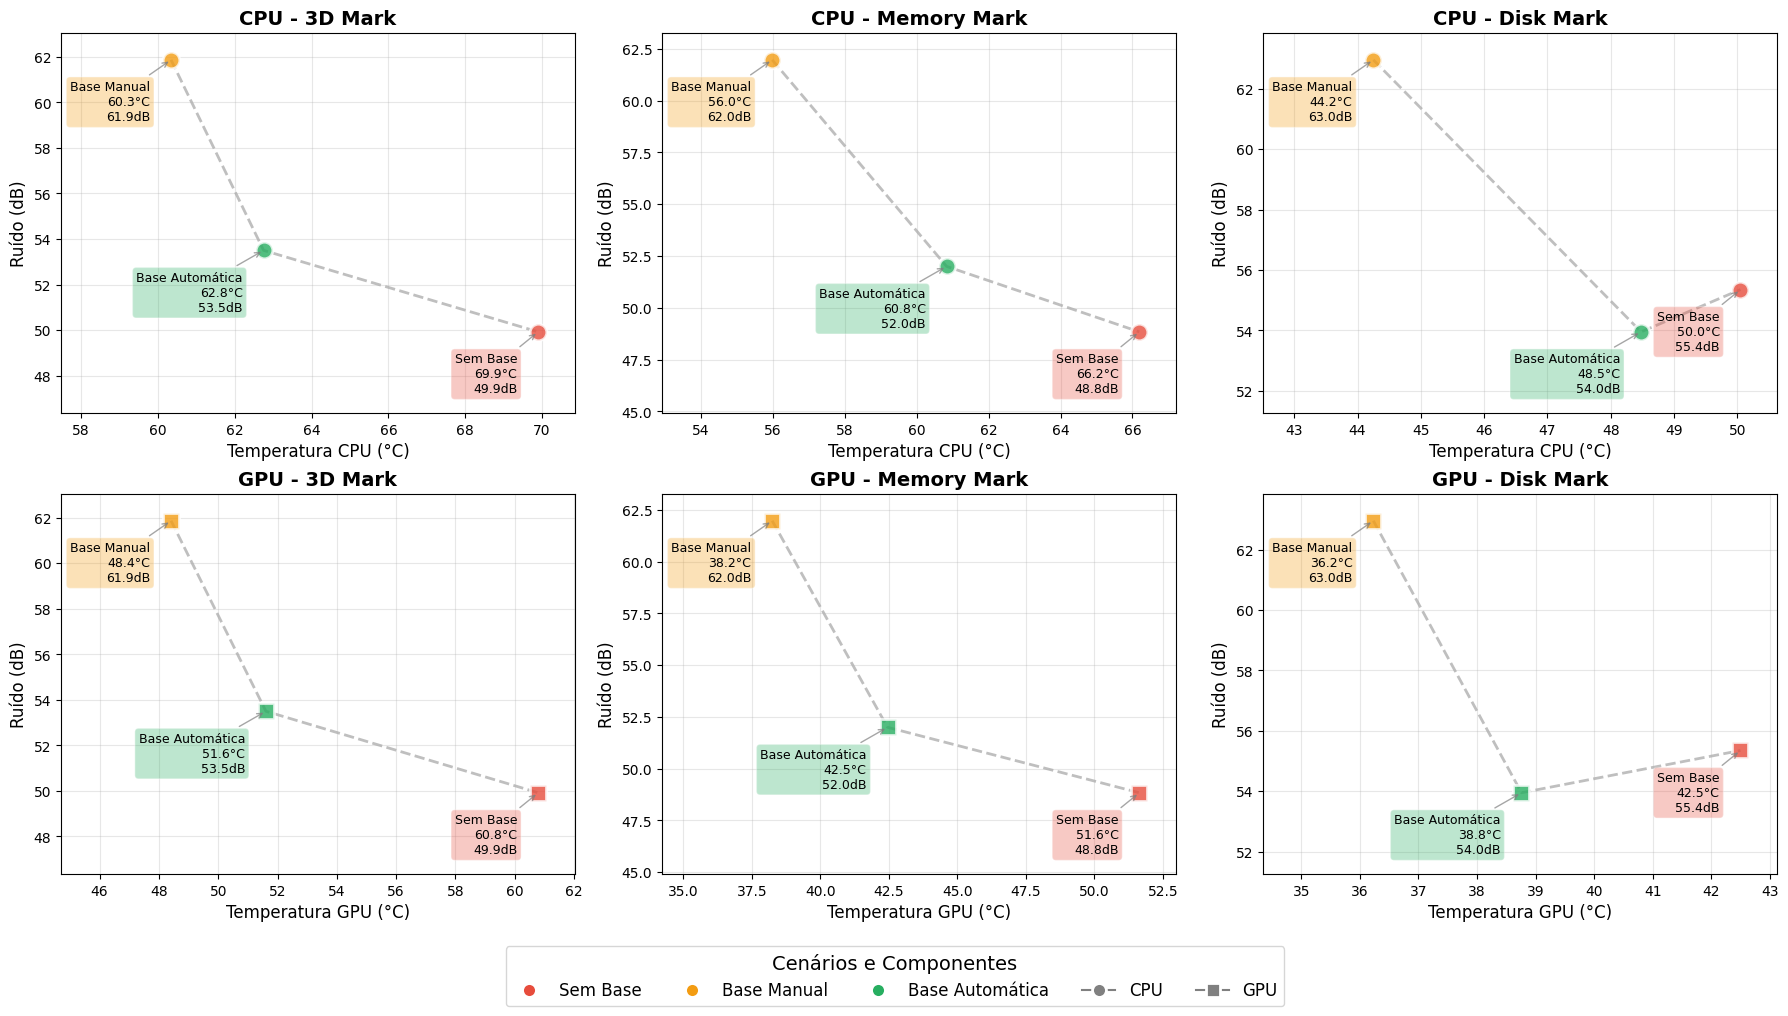

In [ ]:
def plot_temp_ruido_por_teste():
    """
    Cria gráficos de linha para cada teste, mostrando temperatura vs ruído
    com os três cenários como pontos diferentes em cada gráfico
    Anotações posicionadas à esquerda e abaixo de cada ponto
    """
    testes_interesse = ['3D Mark', 'Memory Mark', 'Disk Mark']
    cenarios = ['Sem Base', 'Base Manual', 'Base Automática']

    # Cores para cada cenário
    cores_cenarios = {
        'Sem Base': '#E74C3C',      # Vermelho
        'Base Manual': '#F39C12',   # Laranja
        'Base Automática': '#27AE60' # Verde
    }

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for col, teste in enumerate(testes_interesse):
        ax_cpu = axes[0, col]  # Linha superior: CPU
        ax_gpu = axes[1, col]  # Linha inferior: GPU

        if teste in summary_por_teste:
            df_teste = summary_por_teste[teste]

            # GRÁFICO CPU
            cpu_dados_validos = False
            pontos_cpu = []

            for cenario in cenarios:
                if cenario in df_teste.index:
                    cpu_temp = df_teste.loc[cenario, 'CPU_Temp_Mean']
                    ruido = df_teste.loc[cenario, 'Ruido_Fan_Mean']

                    if pd.notna(cpu_temp) and pd.notna(ruido) and np.isfinite(ruido):
                        pontos_cpu.append((cpu_temp, ruido, cenario))
                        cpu_dados_validos = True

            if cpu_dados_validos:
                # Desenhar a linha conectando os pontos em ordem crescente de temperatura
                if len(pontos_cpu) >= 2:
                    pontos_linha_cpu = sorted(pontos_cpu, key=lambda x: x[0])
                    x_vals = [p[0] for p in pontos_linha_cpu]
                    y_vals = [p[1] for p in pontos_linha_cpu]
                    ax_cpu.plot(x_vals, y_vals, '--', color='gray', alpha=0.5, linewidth=2, zorder=1)

                # Plotar pontos e anotações
                for cpu_temp, ruido, cenario in pontos_cpu:
                    # Plotar ponto
                    ax_cpu.plot(cpu_temp, ruido, 'o',
                              color=cores_cenarios[cenario],
                              markersize=12, markeredgecolor='white',
                              markeredgewidth=2, alpha=0.8, zorder=2)

                    # Adicionar anotação à esquerda e abaixo do ponto
                    ax_cpu.annotate(f'{cenario}\n{cpu_temp:.1f}°C\n{ruido:.1f}dB',
                                  xy=(cpu_temp, ruido),
                                  xytext=(-15, -15),  # 15 pontos à esquerda e 15 pontos abaixo
                                  textcoords="offset points",
                                  ha='right', va='top',  # alinhamento: direita e topo
                                  fontsize=9,
                                  bbox=dict(boxstyle="round,pad=0.3",
                                          facecolor=cores_cenarios[cenario],
                                          alpha=0.3, edgecolor='white'),
                                  arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7),
                                  zorder=3)

                ax_cpu.set_xlabel('Temperatura CPU (°C)', fontsize=12)
                ax_cpu.set_ylabel('Ruído (dB)', fontsize=12)
                ax_cpu.set_title(f'CPU - {teste}', fontsize=14, fontweight='bold')
                ax_cpu.grid(True, alpha=0.3)

                # Ajustar limites com margem extra para as anotações
                if pontos_cpu:
                    x_min, x_max = min(p[0] for p in pontos_cpu), max(p[0] for p in pontos_cpu)
                    y_min, y_max = min(p[1] for p in pontos_cpu), max(p[1] for p in pontos_cpu)
                    x_range = x_max - x_min if x_max > x_min else 1
                    y_range = y_max - y_min if y_max > y_min else 1

                    # Margem extra à esquerda e embaixo para as anotações
                    ax_cpu.set_xlim(x_min - x_range * 0.3, x_max + x_range * 0.1)
                    ax_cpu.set_ylim(y_min - y_range * 0.3, y_max + y_range * 0.1)

            else:
                ax_cpu.text(0.5, 0.5, f'Dados de CPU\nnão disponíveis\npara {teste}',
                           transform=ax_cpu.transAxes, ha='center', va='center',
                           fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                ax_cpu.set_title(f'CPU - {teste}', fontsize=14, fontweight='bold')

            # GRÁFICO GPU
            gpu_dados_validos = False
            pontos_gpu = []

            for cenario in cenarios:
                if cenario in df_teste.index:
                    gpu_temp = df_teste.loc[cenario, 'GPU_Temp_Mean']
                    ruido = df_teste.loc[cenario, 'Ruido_Fan_Mean']

                    if pd.notna(gpu_temp) and pd.notna(ruido) and gpu_temp > 0 and np.isfinite(ruido):
                        pontos_gpu.append((gpu_temp, ruido, cenario))
                        gpu_dados_validos = True

            if gpu_dados_validos:
                # Desenhar a linha conectando os pontos em ordem crescente de temperatura
                if len(pontos_gpu) >= 2:
                    pontos_linha_gpu = sorted(pontos_gpu, key=lambda x: x[0])
                    x_vals = [p[0] for p in pontos_linha_gpu]
                    y_vals = [p[1] for p in pontos_linha_gpu]
                    ax_gpu.plot(x_vals, y_vals, '--', color='gray', alpha=0.5, linewidth=2, zorder=1)

                # Plotar pontos e anotações
                for gpu_temp, ruido, cenario in pontos_gpu:
                    # Plotar ponto
                    ax_gpu.plot(gpu_temp, ruido, 's',
                              color=cores_cenarios[cenario],
                              markersize=12, markeredgecolor='white',
                              markeredgewidth=2, alpha=0.8, zorder=2)

                    # Adicionar anotação à esquerda e abaixo do ponto
                    ax_gpu.annotate(f'{cenario}\n{gpu_temp:.1f}°C\n{ruido:.1f}dB',
                                  xy=(gpu_temp, ruido),
                                  xytext=(-15, -15),  # 15 pontos à esquerda e 15 pontos abaixo
                                  textcoords="offset points",
                                  ha='right', va='top',  # alinhamento: direita e topo
                                  fontsize=9,
                                  bbox=dict(boxstyle="round,pad=0.3",
                                          facecolor=cores_cenarios[cenario],
                                          alpha=0.3, edgecolor='white'),
                                  arrowprops=dict(arrowstyle='->', color='gray', alpha=0.7),
                                  zorder=3)

                ax_gpu.set_xlabel('Temperatura GPU (°C)', fontsize=12)
                ax_gpu.set_ylabel('Ruído (dB)', fontsize=12)
                ax_gpu.set_title(f'GPU - {teste}', fontsize=14, fontweight='bold')
                ax_gpu.grid(True, alpha=0.3)

                # Ajustar limites com margem extra para as anotações
                if pontos_gpu:
                    x_min, x_max = min(p[0] for p in pontos_gpu), max(p[0] for p in pontos_gpu)
                    y_min, y_max = min(p[1] for p in pontos_gpu), max(p[1] for p in pontos_gpu)
                    x_range = x_max - x_min if x_max > x_min else 1
                    y_range = y_max - y_min if y_max > y_min else 1

                    # Margem extra à esquerda e embaixo para as anotações
                    ax_gpu.set_xlim(x_min - x_range * 0.3, x_max + x_range * 0.1)
                    ax_gpu.set_ylim(y_min - y_range * 0.3, y_max + y_range * 0.1)

            else:
                ax_gpu.text(0.5, 0.5, f'Dados de GPU\nnão disponíveis\npara {teste}',
                           transform=ax_gpu.transAxes, ha='center', va='center',
                           fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
                ax_gpu.set_title(f'GPU - {teste}', fontsize=14, fontweight='bold')

        else:
            # Caso o teste não exista
            for ax in [axes[0, col], axes[1, col]]:
                ax.text(0.5, 0.5, f'Teste {teste}\nnão encontrado',
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
                ax.set_title(f'{teste}', fontsize=14, fontweight='bold')

    # Legenda geral na parte inferior
    from matplotlib.lines import Line2D

    # Elementos da legenda para cenários
    legend_cenarios = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cor,
                             markersize=10, label=cenario, markeredgecolor='white',
                             markeredgewidth=2)
                      for cenario, cor in cores_cenarios.items()]

    # Elementos da legenda para componentes
    legend_componentes = [
        Line2D([0], [0], marker='o', color='gray', markersize=10,
               label='CPU', markeredgecolor='white', markeredgewidth=2),
        Line2D([0], [0], marker='s', color='gray', markersize=10,
               label='GPU', markeredgecolor='white', markeredgewidth=2)
    ]

    # Combinar as legendas
    all_legend_elements = legend_cenarios + legend_componentes

    # Legenda centralizada abaixo de toda a imagem
    fig.legend(handles=all_legend_elements, loc='lower center',
              bbox_to_anchor=(0.5, -0.02), ncol=5, fontsize=12,
              title='Cenários e Componentes', title_fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    plt.show()

# Chamar a função
plot_temp_ruido_por_teste()